In [26]:
import numpy as np
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

from lib.data_preprocessing import remove_correlated_columns, normalize_data
from lib.ds.bird_classes import NUM_CLASSES
from lib.ds.dataset_loading import load_all_data
from lib.ds.dataset_splitting import split
from lib.ds.torch_dataset import create_data_loader
from lib.model.attention_classifier import AttentionClassifier, AttentionClassifierHyperParameters
from lib.attention_classifier_training import train_attention_classifier_with_cv, train_attention_classifier, evaluate_attention_classifier
from lib.training_hyper_parameters import TrainingHyperParameters
from lib.ds.numpy_dataset import NumpyDataset
from lib.model.model_persistence import save_model, load_model
from lib.random import set_random_seed
from lib.metrics import calculate_average_metrics_for_final_epoch_of_folds, calculate_average_metrics_per_epoch
import lib.torch_device as tdev
import torch.optim.lr_scheduler as lr_scheduler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# tdev.PREFERRED = 'cpu'
device = tdev.get_torch_device()
device

device(type='cuda', index=0)

In [3]:
data_train, labels_train, data_test, labels_test = split(*load_all_data('dataset'), seed=69421)

In [4]:
data_train, data_test = remove_correlated_columns(data_train, data_test)

correlated_columns_to_drop = array([  0,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214

In [5]:
data_train.shape

(960, 100, 264)

In [6]:
set_random_seed(42)
subset_indices = [
    bird * data_train.shape[0] // 6 + sample_nr
    for bird in range(6)
    for sample_nr in range(10)
]
# data_train_subset = data_train[subset_indices, :, :]
# labels_train_subset = labels_train[subset_indices, :]
data_train_subset = data_train[subset_indices, :, :]
labels_train_subset = labels_train[subset_indices, :]
print(data_train_subset.shape)
print(labels_train_subset.shape)

(60, 100, 264)
(60, 100)


# Hyper Parameters

In [63]:
hyper_parameters = AttentionClassifierHyperParameters(
    in_features=data_train.shape[-1],
    out_features=NUM_CLASSES,
    
    self_attention=True,
    d_model=60,
    num_heads=12,
    stack_size=1,
    dropout=0.1,
    
    in_linear_hidden_out_features=[48, 48],
    out_linear_hidden_out_features=[64],
    
    linear_activation_provider=lambda: nn.LeakyReLU(),
)

In [71]:
def create_training_hyper_parameters(epoch_multiplier: float):
    training_hyper_parameters = TrainingHyperParameters(
        batch_size=32,

        optimizer_provider=lambda model, lr: optim.Adamax(
            model.parameters(),
            lr=lr,
            betas=(0.9, 0.98),
            eps=1e-9
        ),

        num_epochs=int(100 * epoch_multiplier),
        lr=1e-2,
        lr_scheduler_provider=lambda optimizer: lr_scheduler.MultiStepLR(
            optimizer, 
            milestones=[int(m * epoch_multiplier) for m in [8, 20, 50, 80]],
            gamma=0.5
        )
    )

# Training

## Cross Validation

Training fold 0
Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 15.8275,  9.6494, 10.6295, 36.9184, 17.7606, 19.8364],
       device='cuda:0')
Training Epoch   0/50 : lr = 0.01, avg_loss = 0.000500, num_samples = 86400, num_correct =  9584, acc = 0.110926, bacc = 0.282128
Evaluation Epoch   0/50 : avg_loss = 0.016040, num_samples =  9600, num_correct =  2250, acc = 0.234375, bacc = 0.575552
Training Epoch   1/50 : lr = 0.01, avg_loss = 0.000303, num_samples = 86400, num_correct = 19801, acc = 0.229178, bacc = 0.573526
Evaluation Epoch   1/50 : avg_loss = 0.041711, num_samples =  9600, num_correct =  4011, acc = 0.417812, bacc = 0.731517
Training Epoch   2/50 : lr = 0.01, avg_loss = 0.000196, num_samples = 86400, num_correct = 44214, acc = 0.511736, bacc = 0.768284
Evaluation Epoch   2/50 : avg_loss = 0.133657, num_samples =  9600, num_correct =  5378, acc = 0.560208, bacc = 0.765781
Training Epoch   3/50 : lr = 0.005, avg_loss = 0.000149, num_samples =

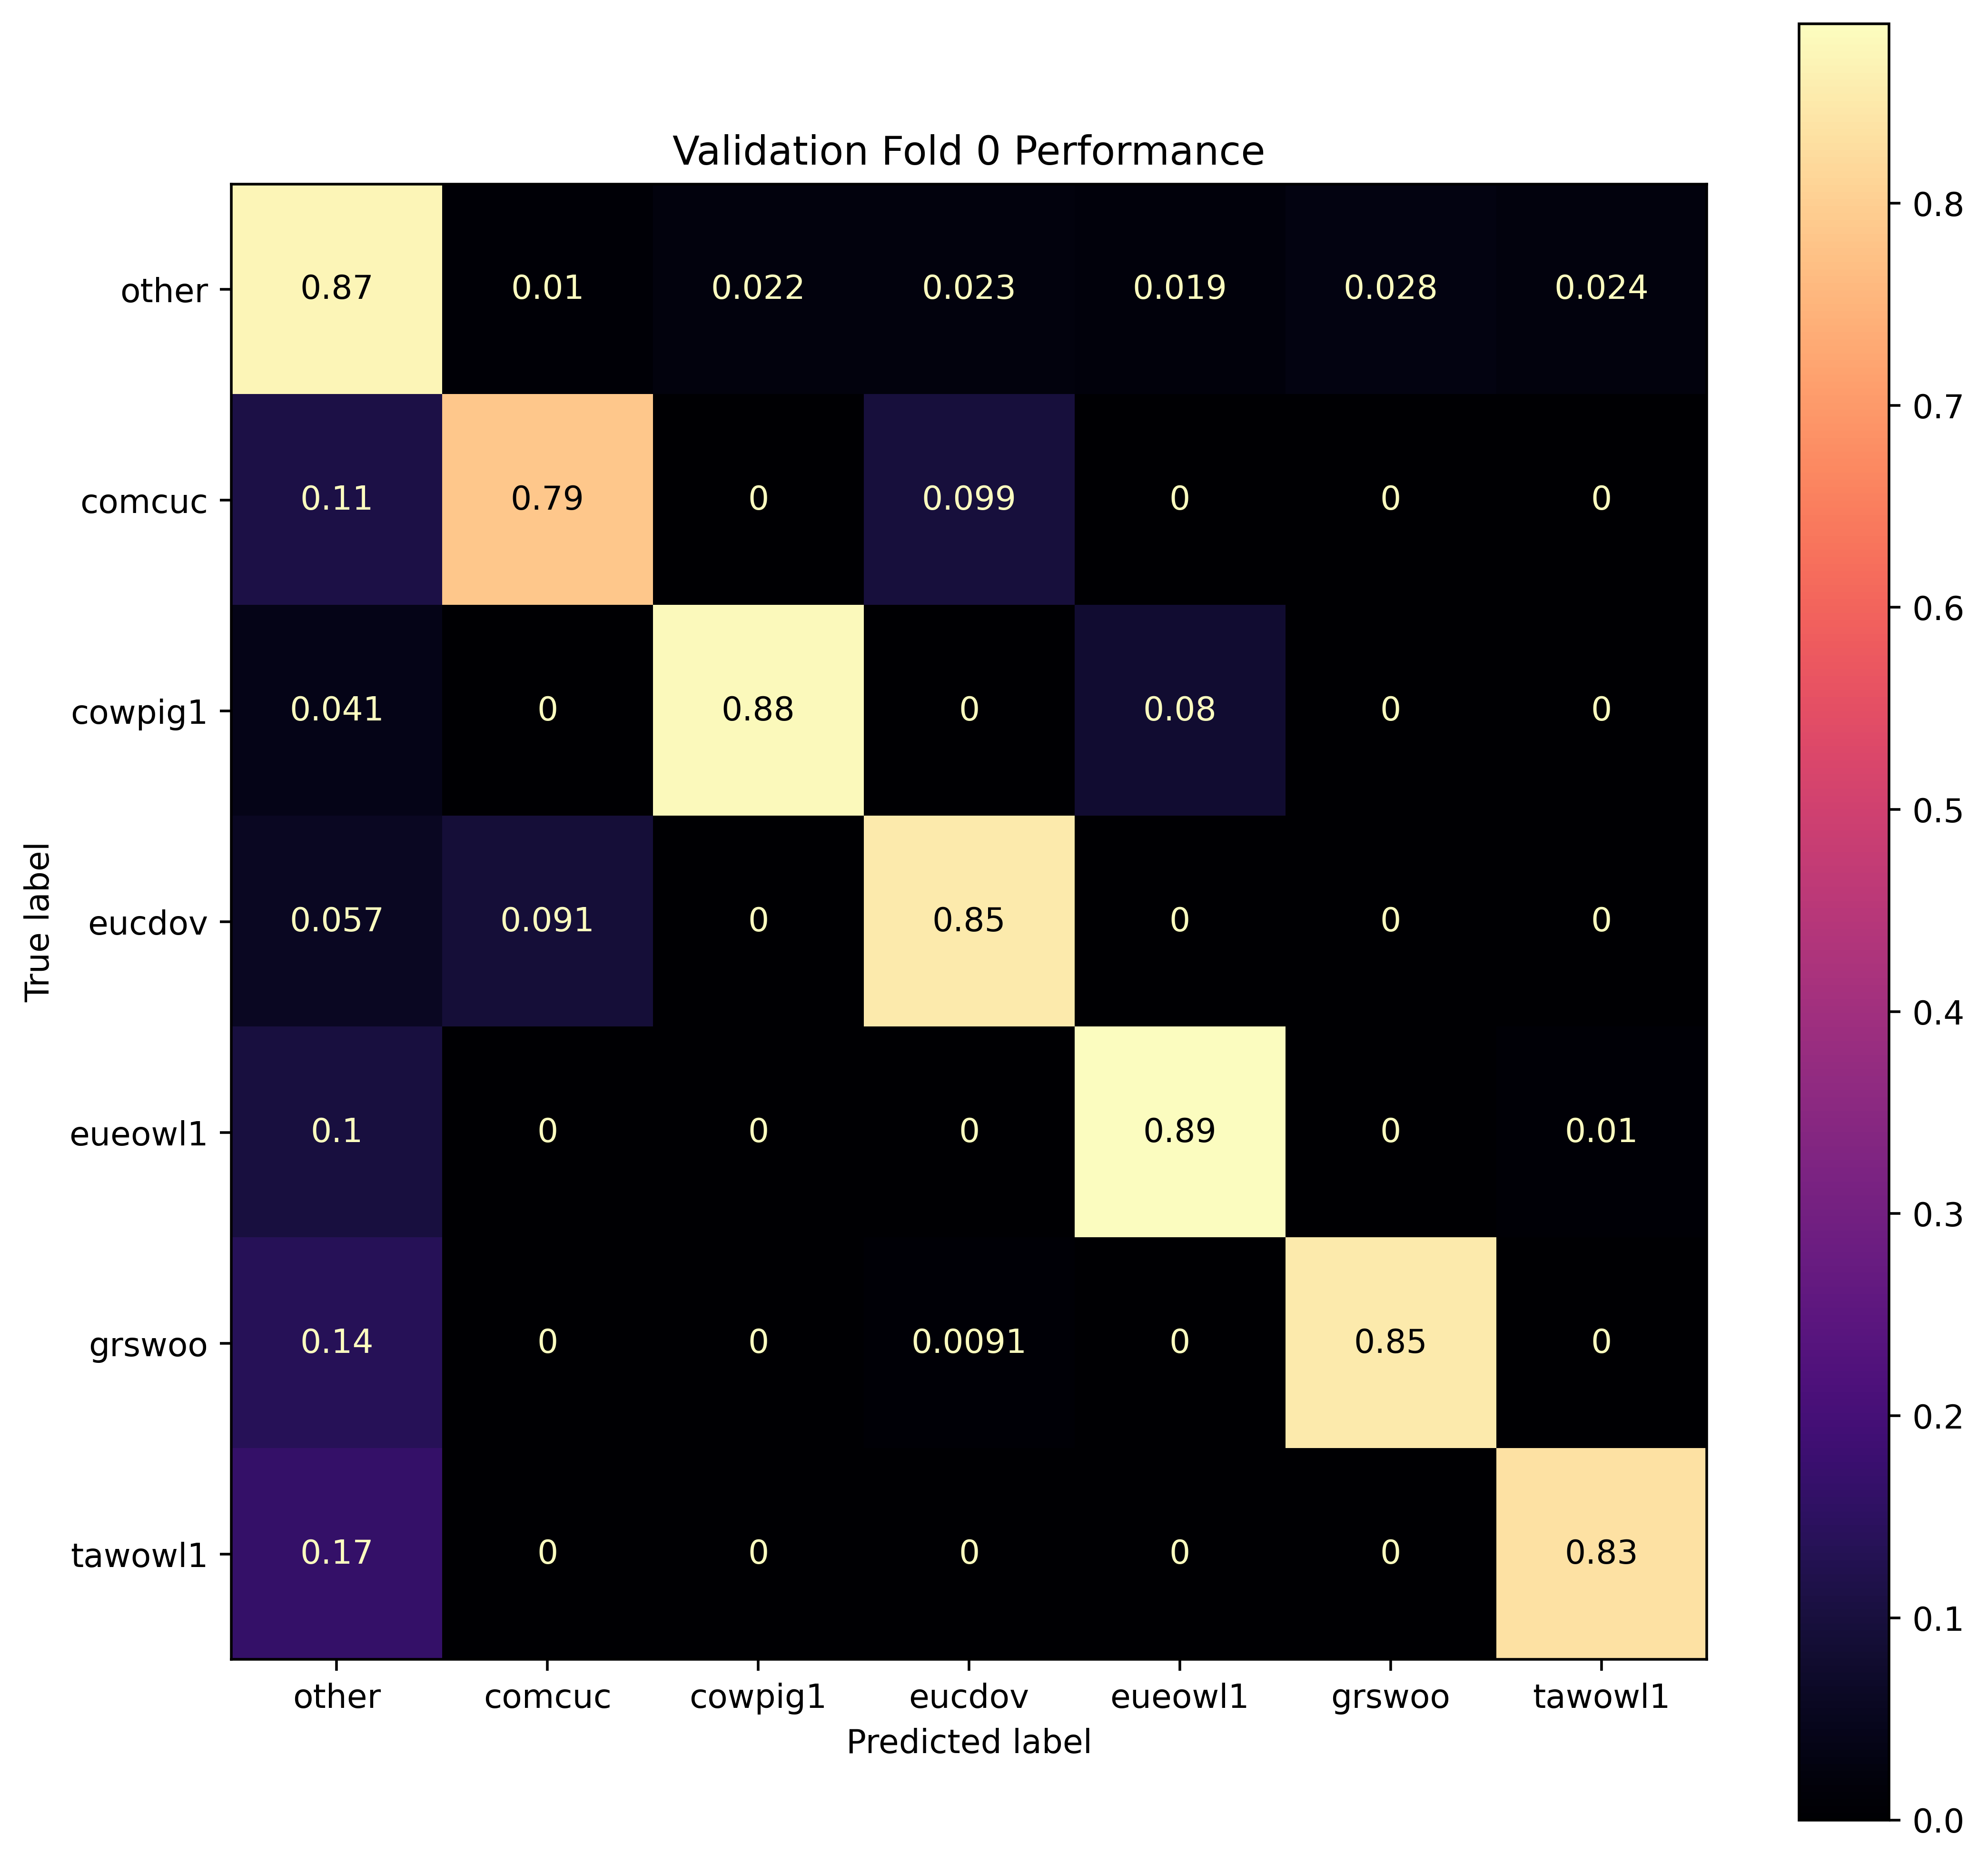

Saved model with scaler as "attention_classifier cv2023-05-17_23.17 fold-0"
Training fold 1
Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 15.3660,  9.3527, 10.3101, 35.4703, 17.9944, 19.5368],
       device='cuda:0')
Training Epoch   0/50 : lr = 0.01, avg_loss = 0.000500, num_samples = 86400, num_correct =  9938, acc = 0.115023, bacc = 0.296679
Evaluation Epoch   0/50 : avg_loss = 0.000471, num_samples =  9600, num_correct =  2000, acc = 0.208333, bacc = 0.470961
Training Epoch   1/50 : lr = 0.01, avg_loss = 0.000371, num_samples = 86400, num_correct = 17545, acc = 0.203067, bacc = 0.512488
Evaluation Epoch   1/50 : avg_loss = 0.000412, num_samples =  9600, num_correct =  3389, acc = 0.353021, bacc = 0.650004
Training Epoch   2/50 : lr = 0.01, avg_loss = 0.000239, num_samples = 86400, num_correct = 34899, acc = 0.403924, bacc = 0.703823
Evaluation Epoch   2/50 : avg_loss = 0.000321, num_samples =  9600, num_correct =  5703, acc = 0.594063, bacc = 0.8

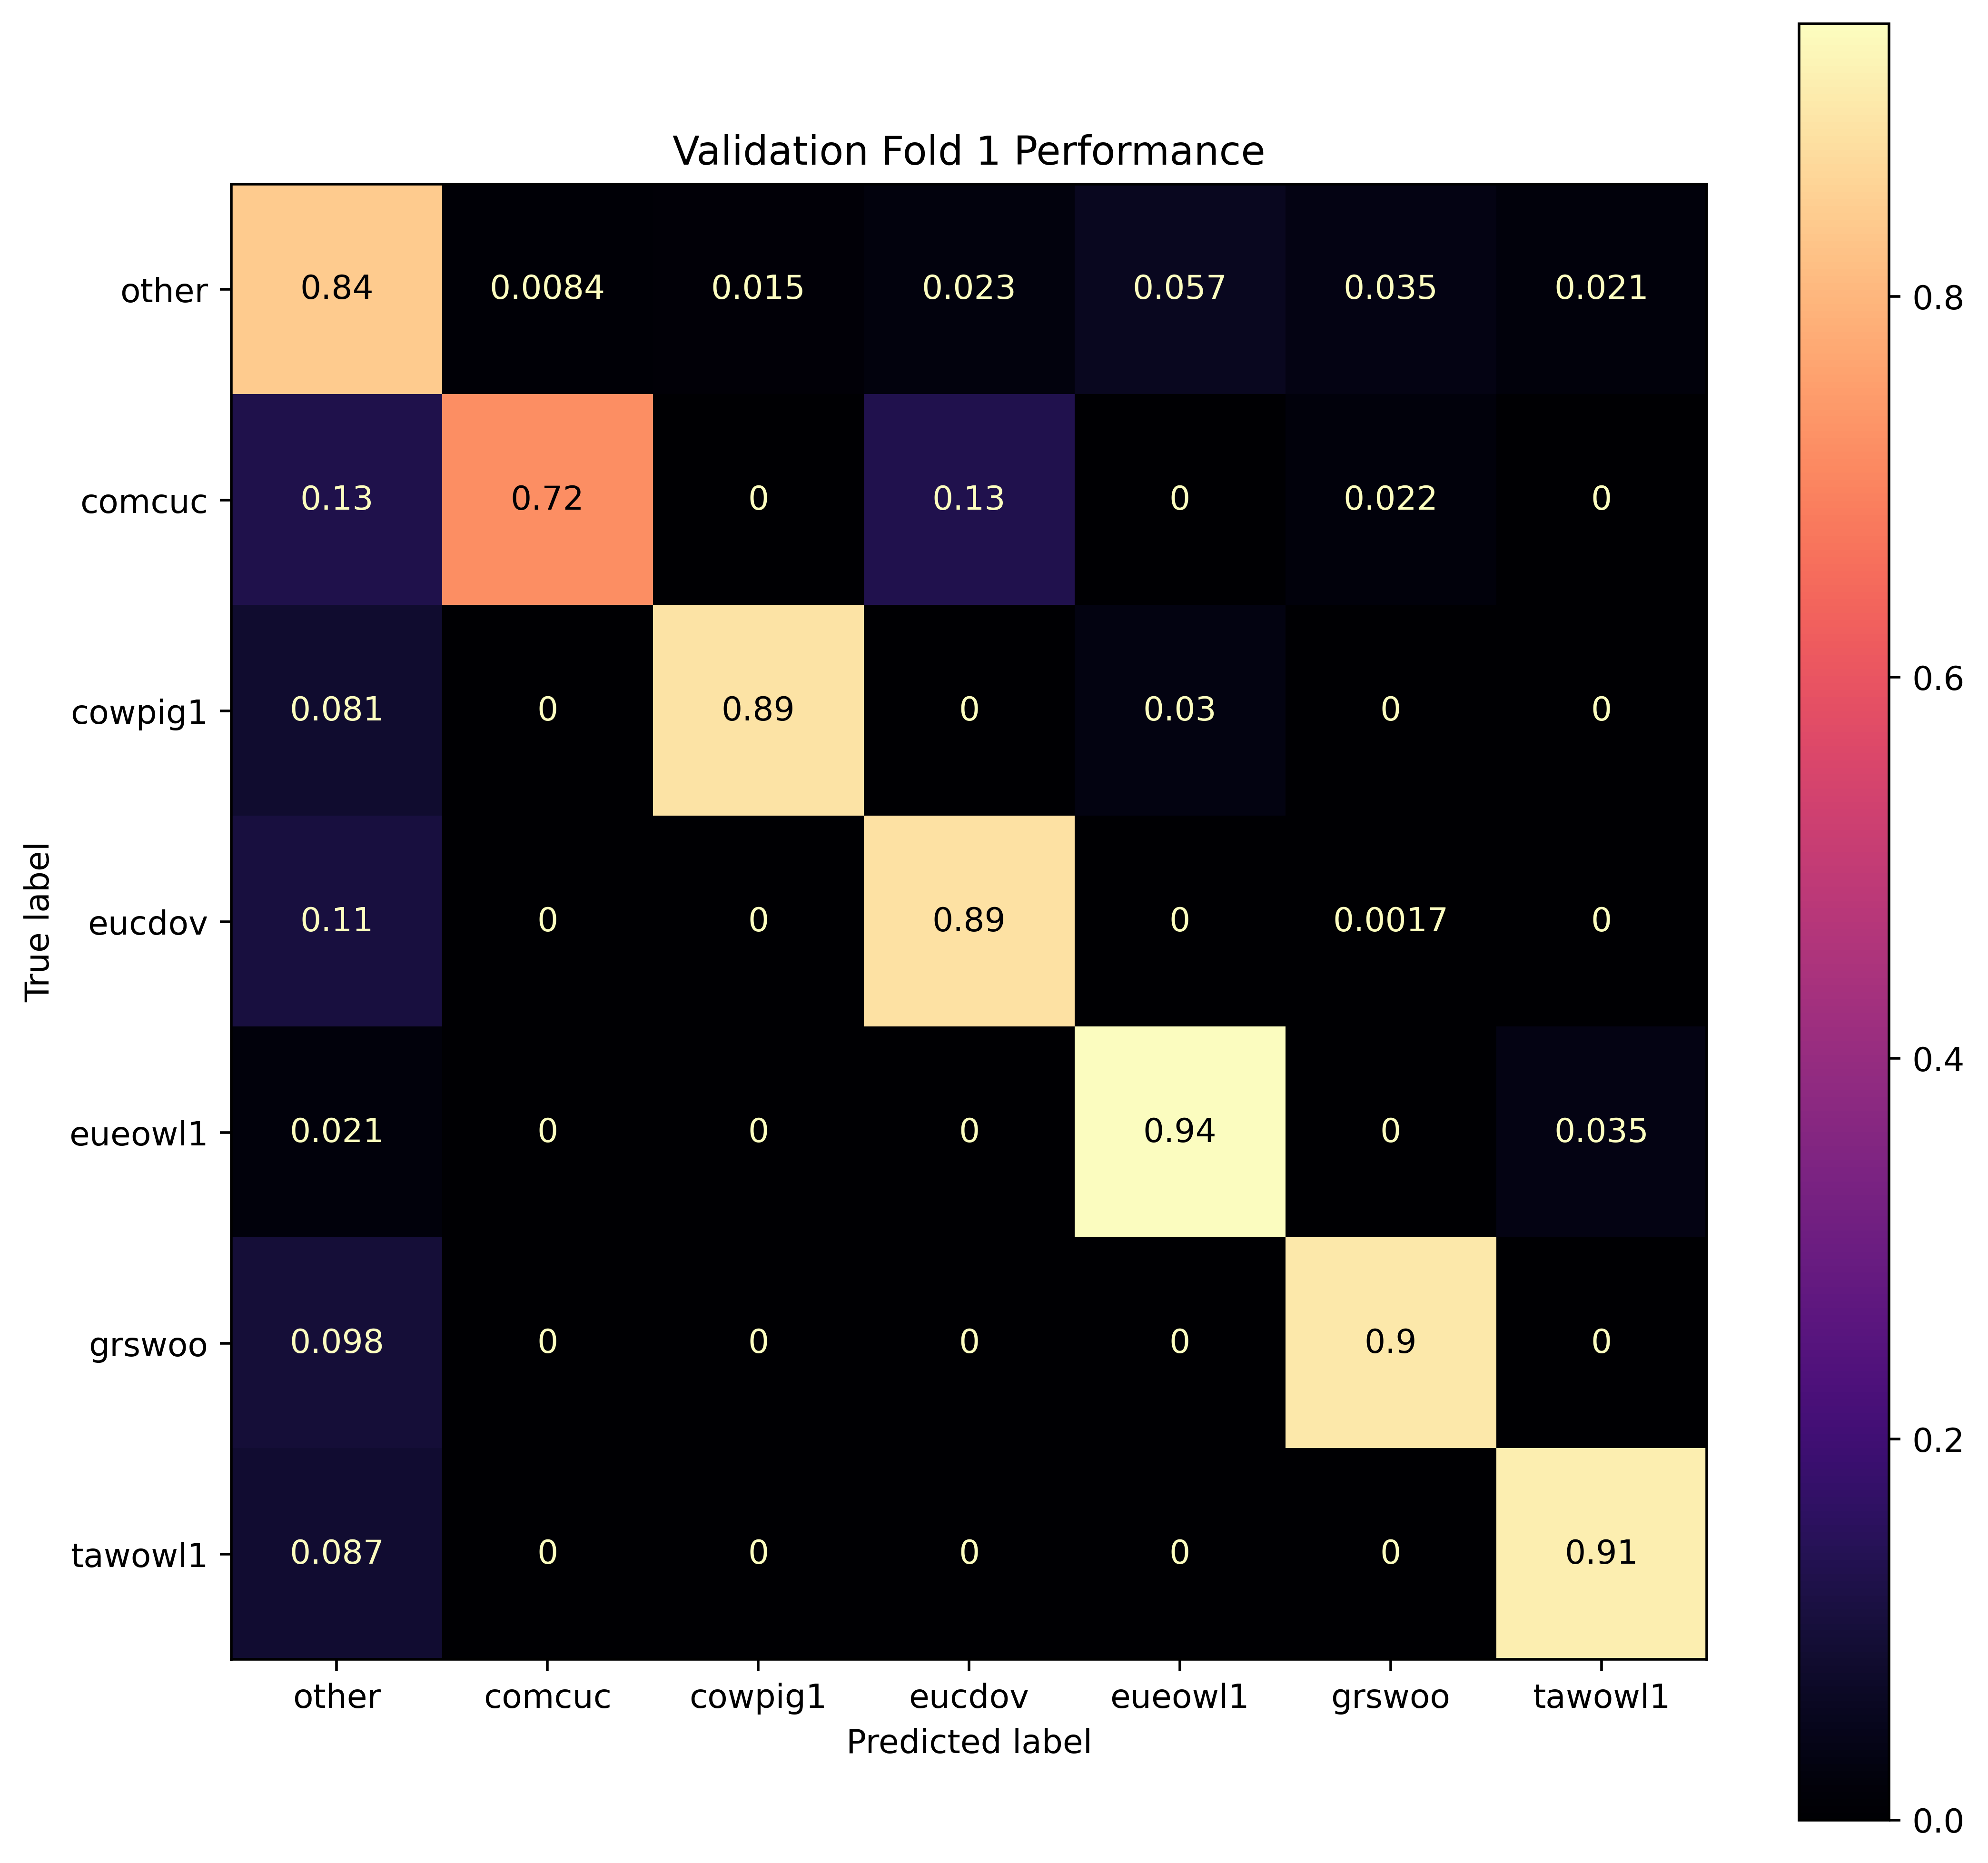

Saved model with scaler as "attention_classifier cv2023-05-17_23.17 fold-1"
Training fold 2
Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 15.2621,  9.1518, 10.3538, 36.6018, 18.4547, 19.1561],
       device='cuda:0')
Training Epoch   0/50 : lr = 0.01, avg_loss = 0.000518, num_samples = 86400, num_correct = 10132, acc = 0.117269, bacc = 0.254817
Evaluation Epoch   0/50 : avg_loss = 0.000483, num_samples =  9600, num_correct =  1857, acc = 0.193438, bacc = 0.506991
Training Epoch   1/50 : lr = 0.01, avg_loss = 0.000339, num_samples = 86400, num_correct = 18839, acc = 0.218044, bacc = 0.573172
Evaluation Epoch   1/50 : avg_loss = 0.000461, num_samples =  9600, num_correct =  2670, acc = 0.278125, bacc = 0.712271
Training Epoch   2/50 : lr = 0.01, avg_loss = 0.000202, num_samples = 86400, num_correct = 30930, acc = 0.357986, bacc = 0.770420
Evaluation Epoch   2/50 : avg_loss = 0.000443, num_samples =  9600, num_correct =  4801, acc = 0.500104, bacc = 0.8

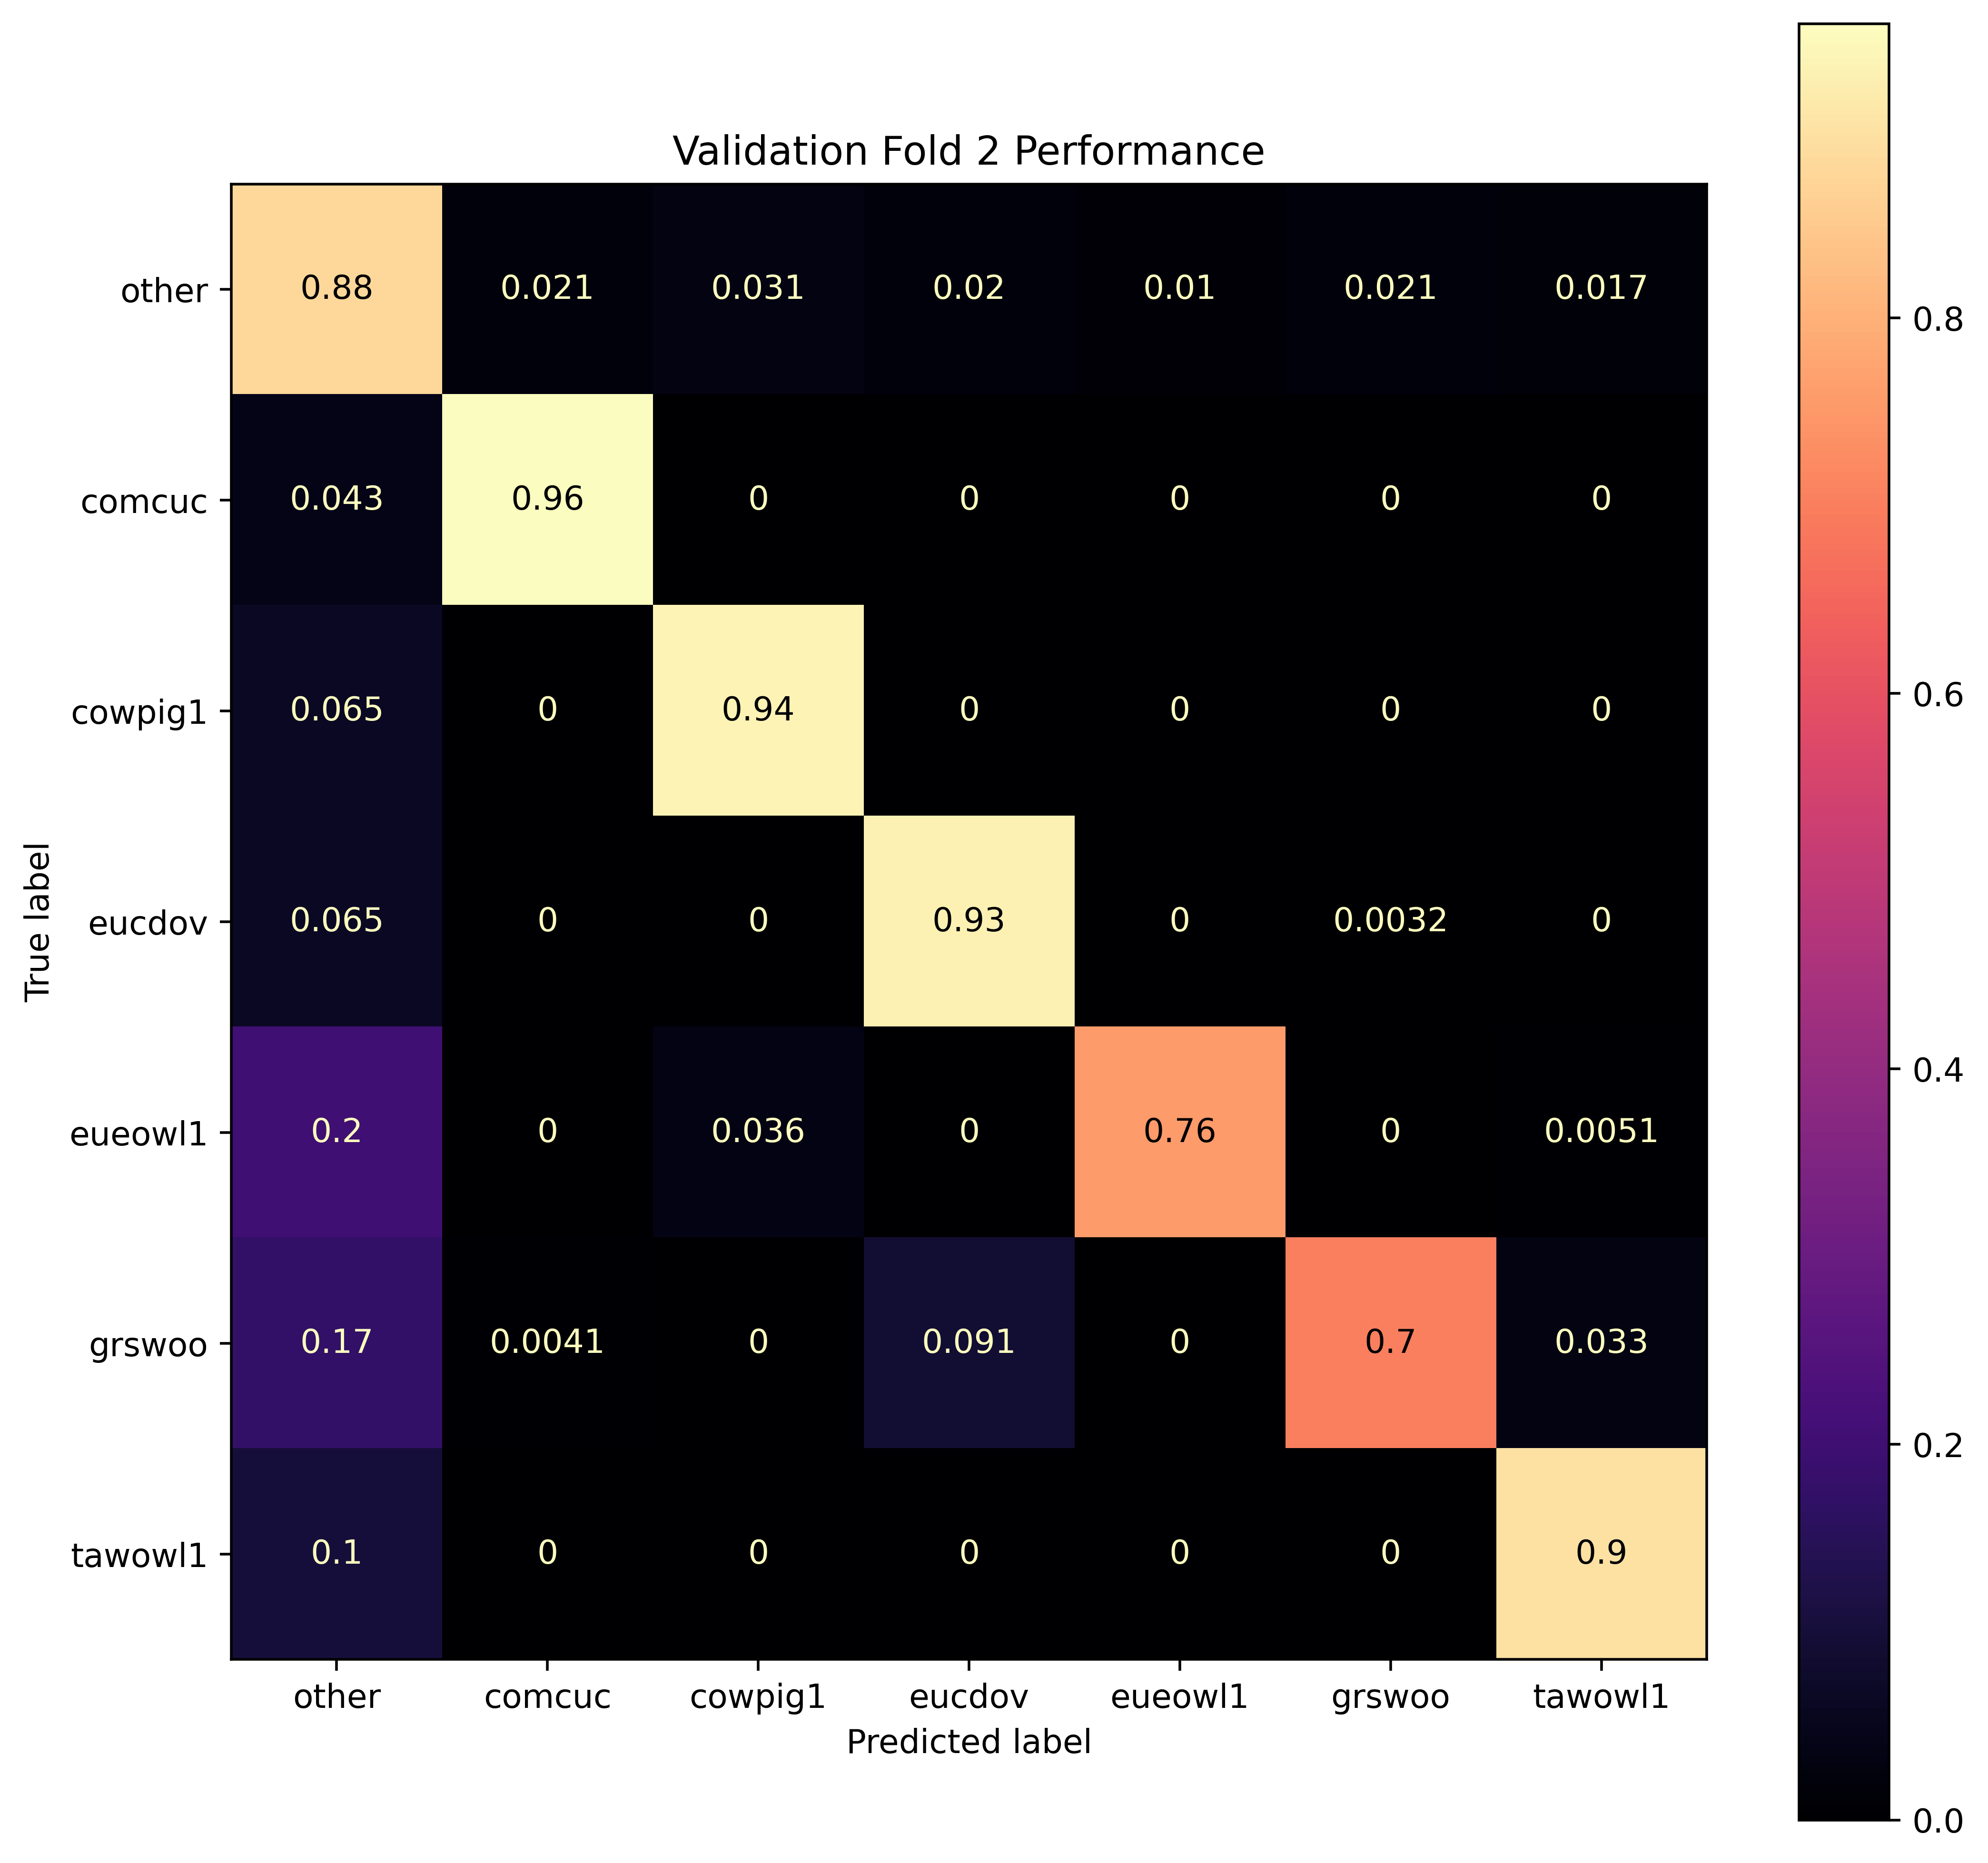

Saved model with scaler as "attention_classifier cv2023-05-17_23.17 fold-2"
Training fold 3
Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 15.5361,  9.3948, 10.4847, 38.6121, 18.1551, 19.8071],
       device='cuda:0')
Training Epoch   0/50 : lr = 0.01, avg_loss = 0.000494, num_samples = 86400, num_correct = 10120, acc = 0.117130, bacc = 0.324329
Evaluation Epoch   0/50 : avg_loss = 0.000464, num_samples =  9600, num_correct =  1990, acc = 0.207292, bacc = 0.605798
Training Epoch   1/50 : lr = 0.01, avg_loss = 0.000282, num_samples = 86400, num_correct = 21254, acc = 0.245995, bacc = 0.665015
Evaluation Epoch   1/50 : avg_loss = 0.000411, num_samples =  9600, num_correct =  3293, acc = 0.343021, bacc = 0.758734
Training Epoch   2/50 : lr = 0.01, avg_loss = 0.000187, num_samples = 86400, num_correct = 33218, acc = 0.384468, bacc = 0.775542
Evaluation Epoch   2/50 : avg_loss = 0.000305, num_samples =  9600, num_correct =  5261, acc = 0.548021, bacc = 0.8

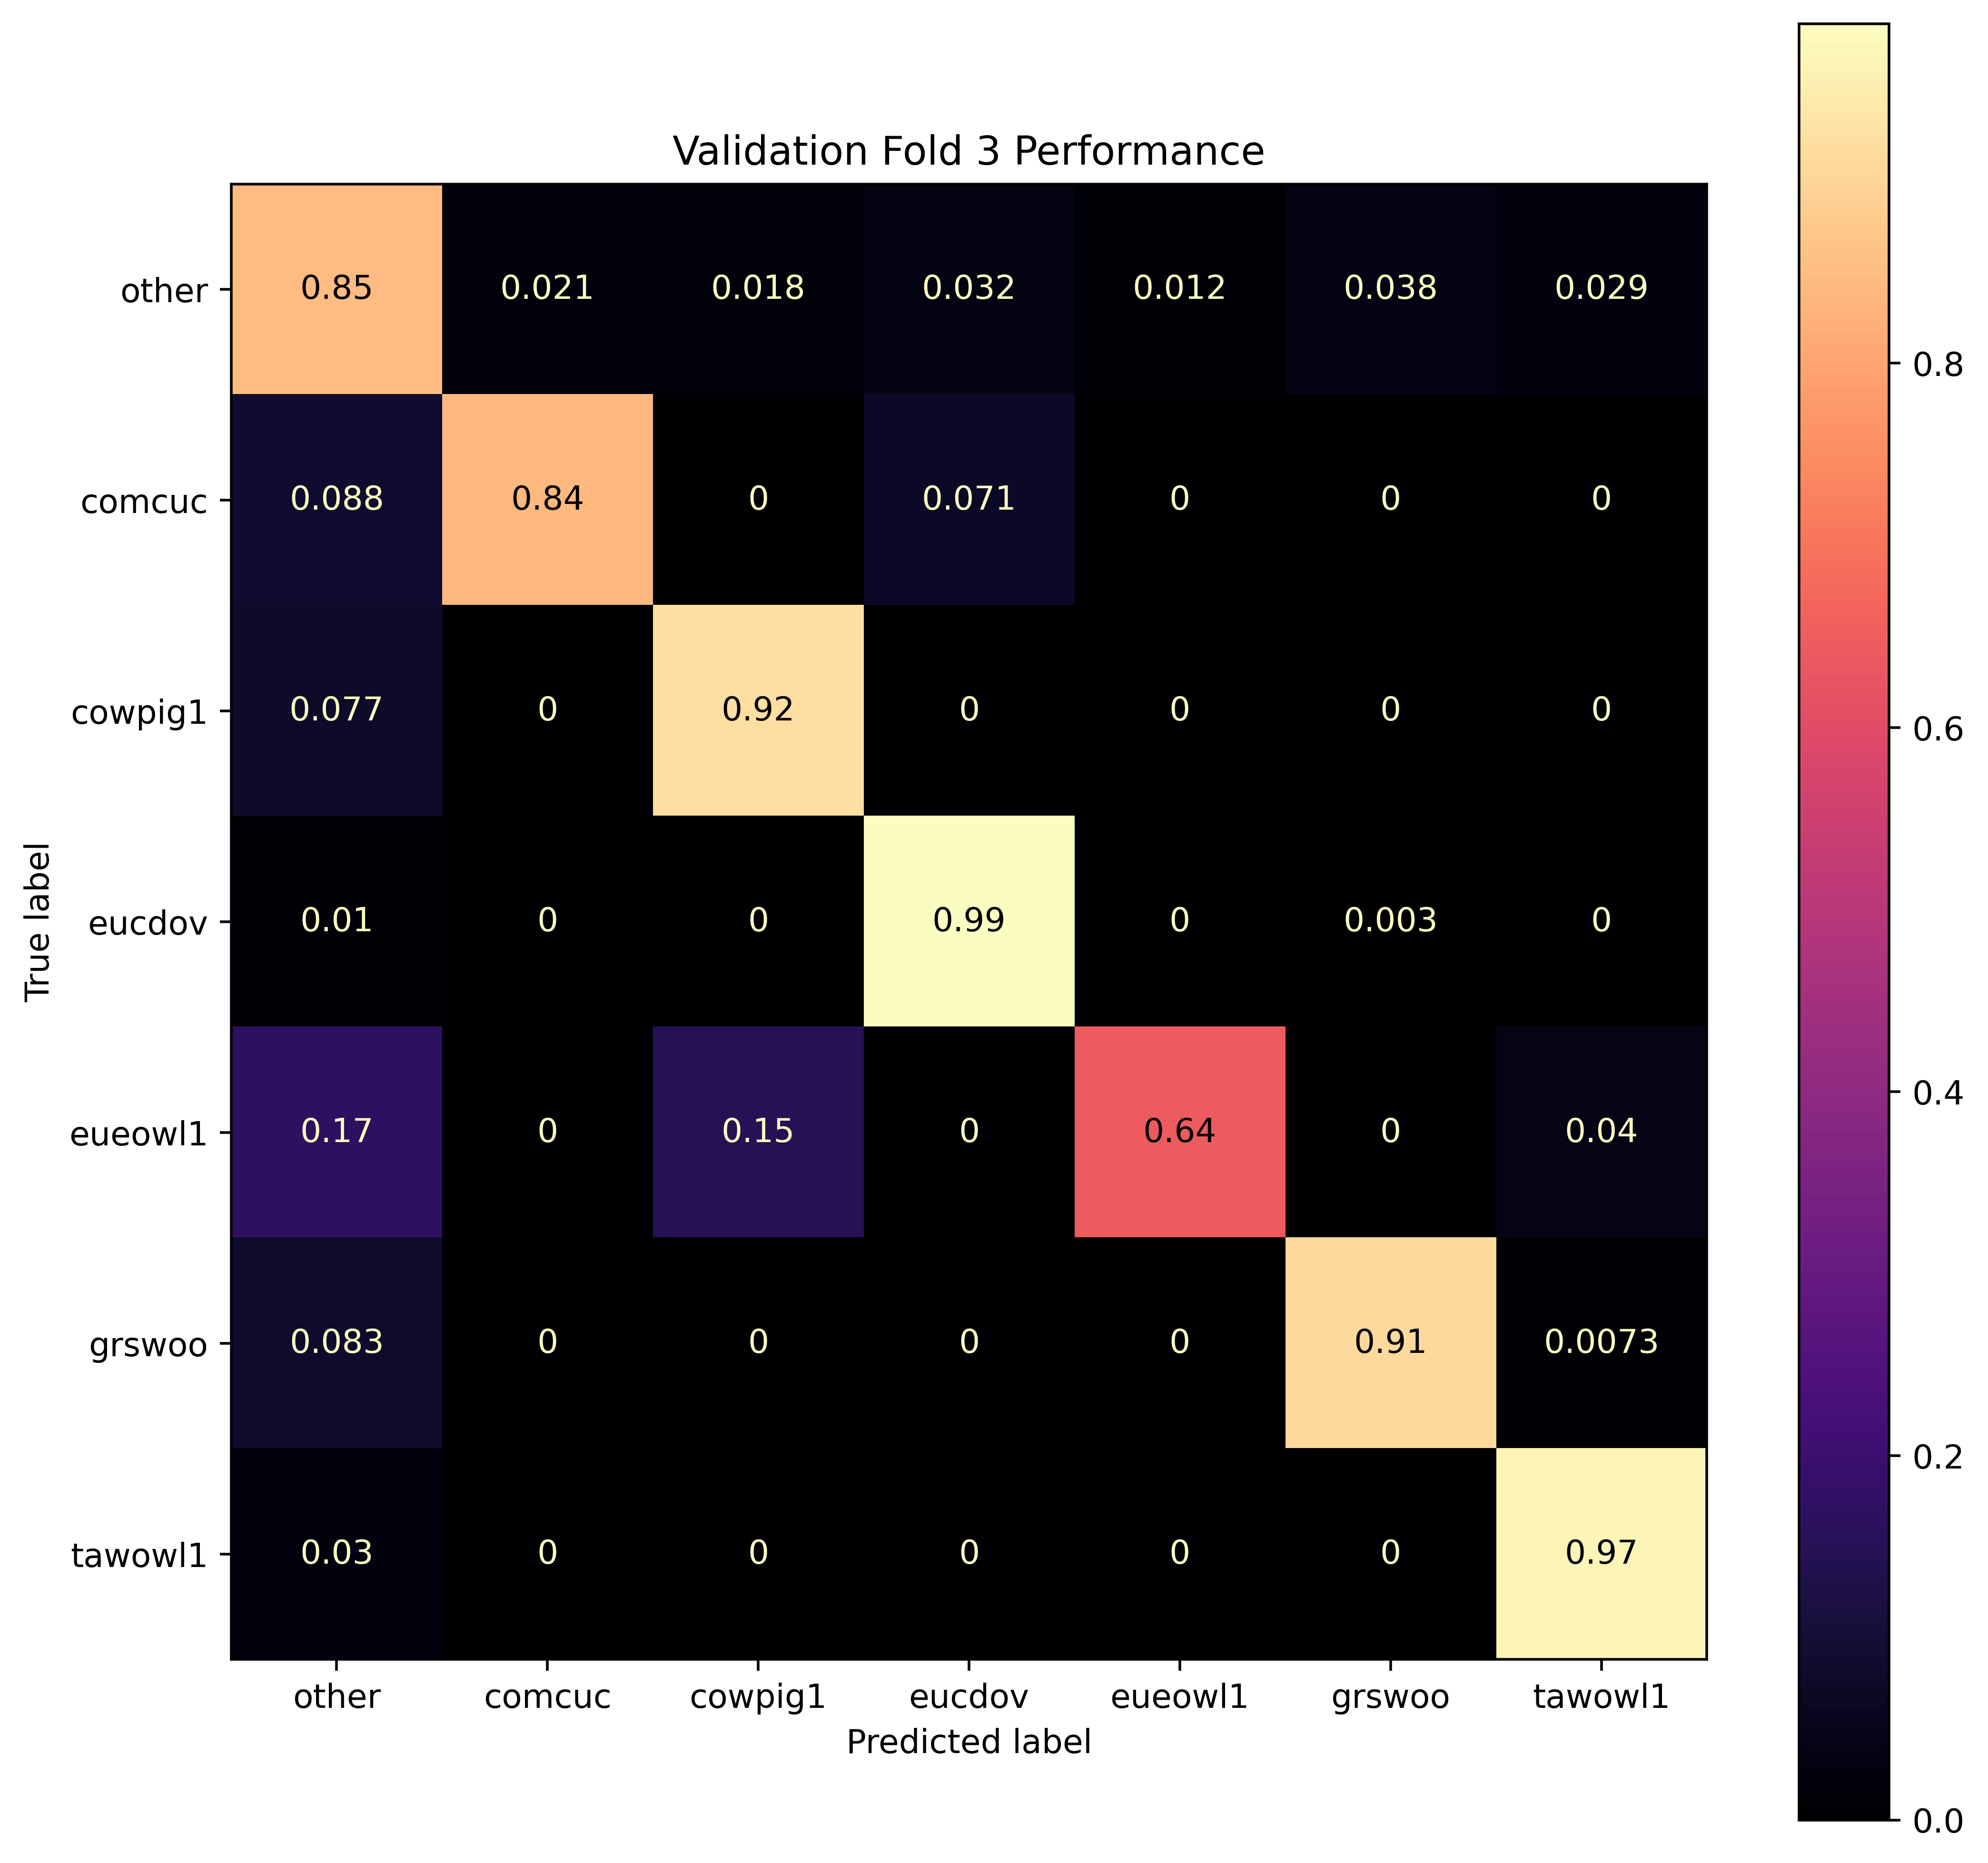

Saved model with scaler as "attention_classifier cv2023-05-17_23.17 fold-3"
Training fold 4
Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 15.1846,  9.1787, 10.5581, 36.7640, 17.6949, 19.7380],
       device='cuda:0')
Training Epoch   0/50 : lr = 0.01, avg_loss = 0.000504, num_samples = 86400, num_correct = 11084, acc = 0.128287, bacc = 0.227524
Evaluation Epoch   0/50 : avg_loss = 0.000509, num_samples =  9600, num_correct =  1045, acc = 0.108854, bacc = 0.342622
Training Epoch   1/50 : lr = 0.01, avg_loss = 0.000361, num_samples = 86400, num_correct = 14532, acc = 0.168194, bacc = 0.507819
Evaluation Epoch   1/50 : avg_loss = 0.000469, num_samples =  9600, num_correct =  2381, acc = 0.248021, bacc = 0.615251
Training Epoch   2/50 : lr = 0.01, avg_loss = 0.000260, num_samples = 86400, num_correct = 30141, acc = 0.348854, bacc = 0.696291
Evaluation Epoch   2/50 : avg_loss = 0.000410, num_samples =  9600, num_correct =  4939, acc = 0.514479, bacc = 0.7

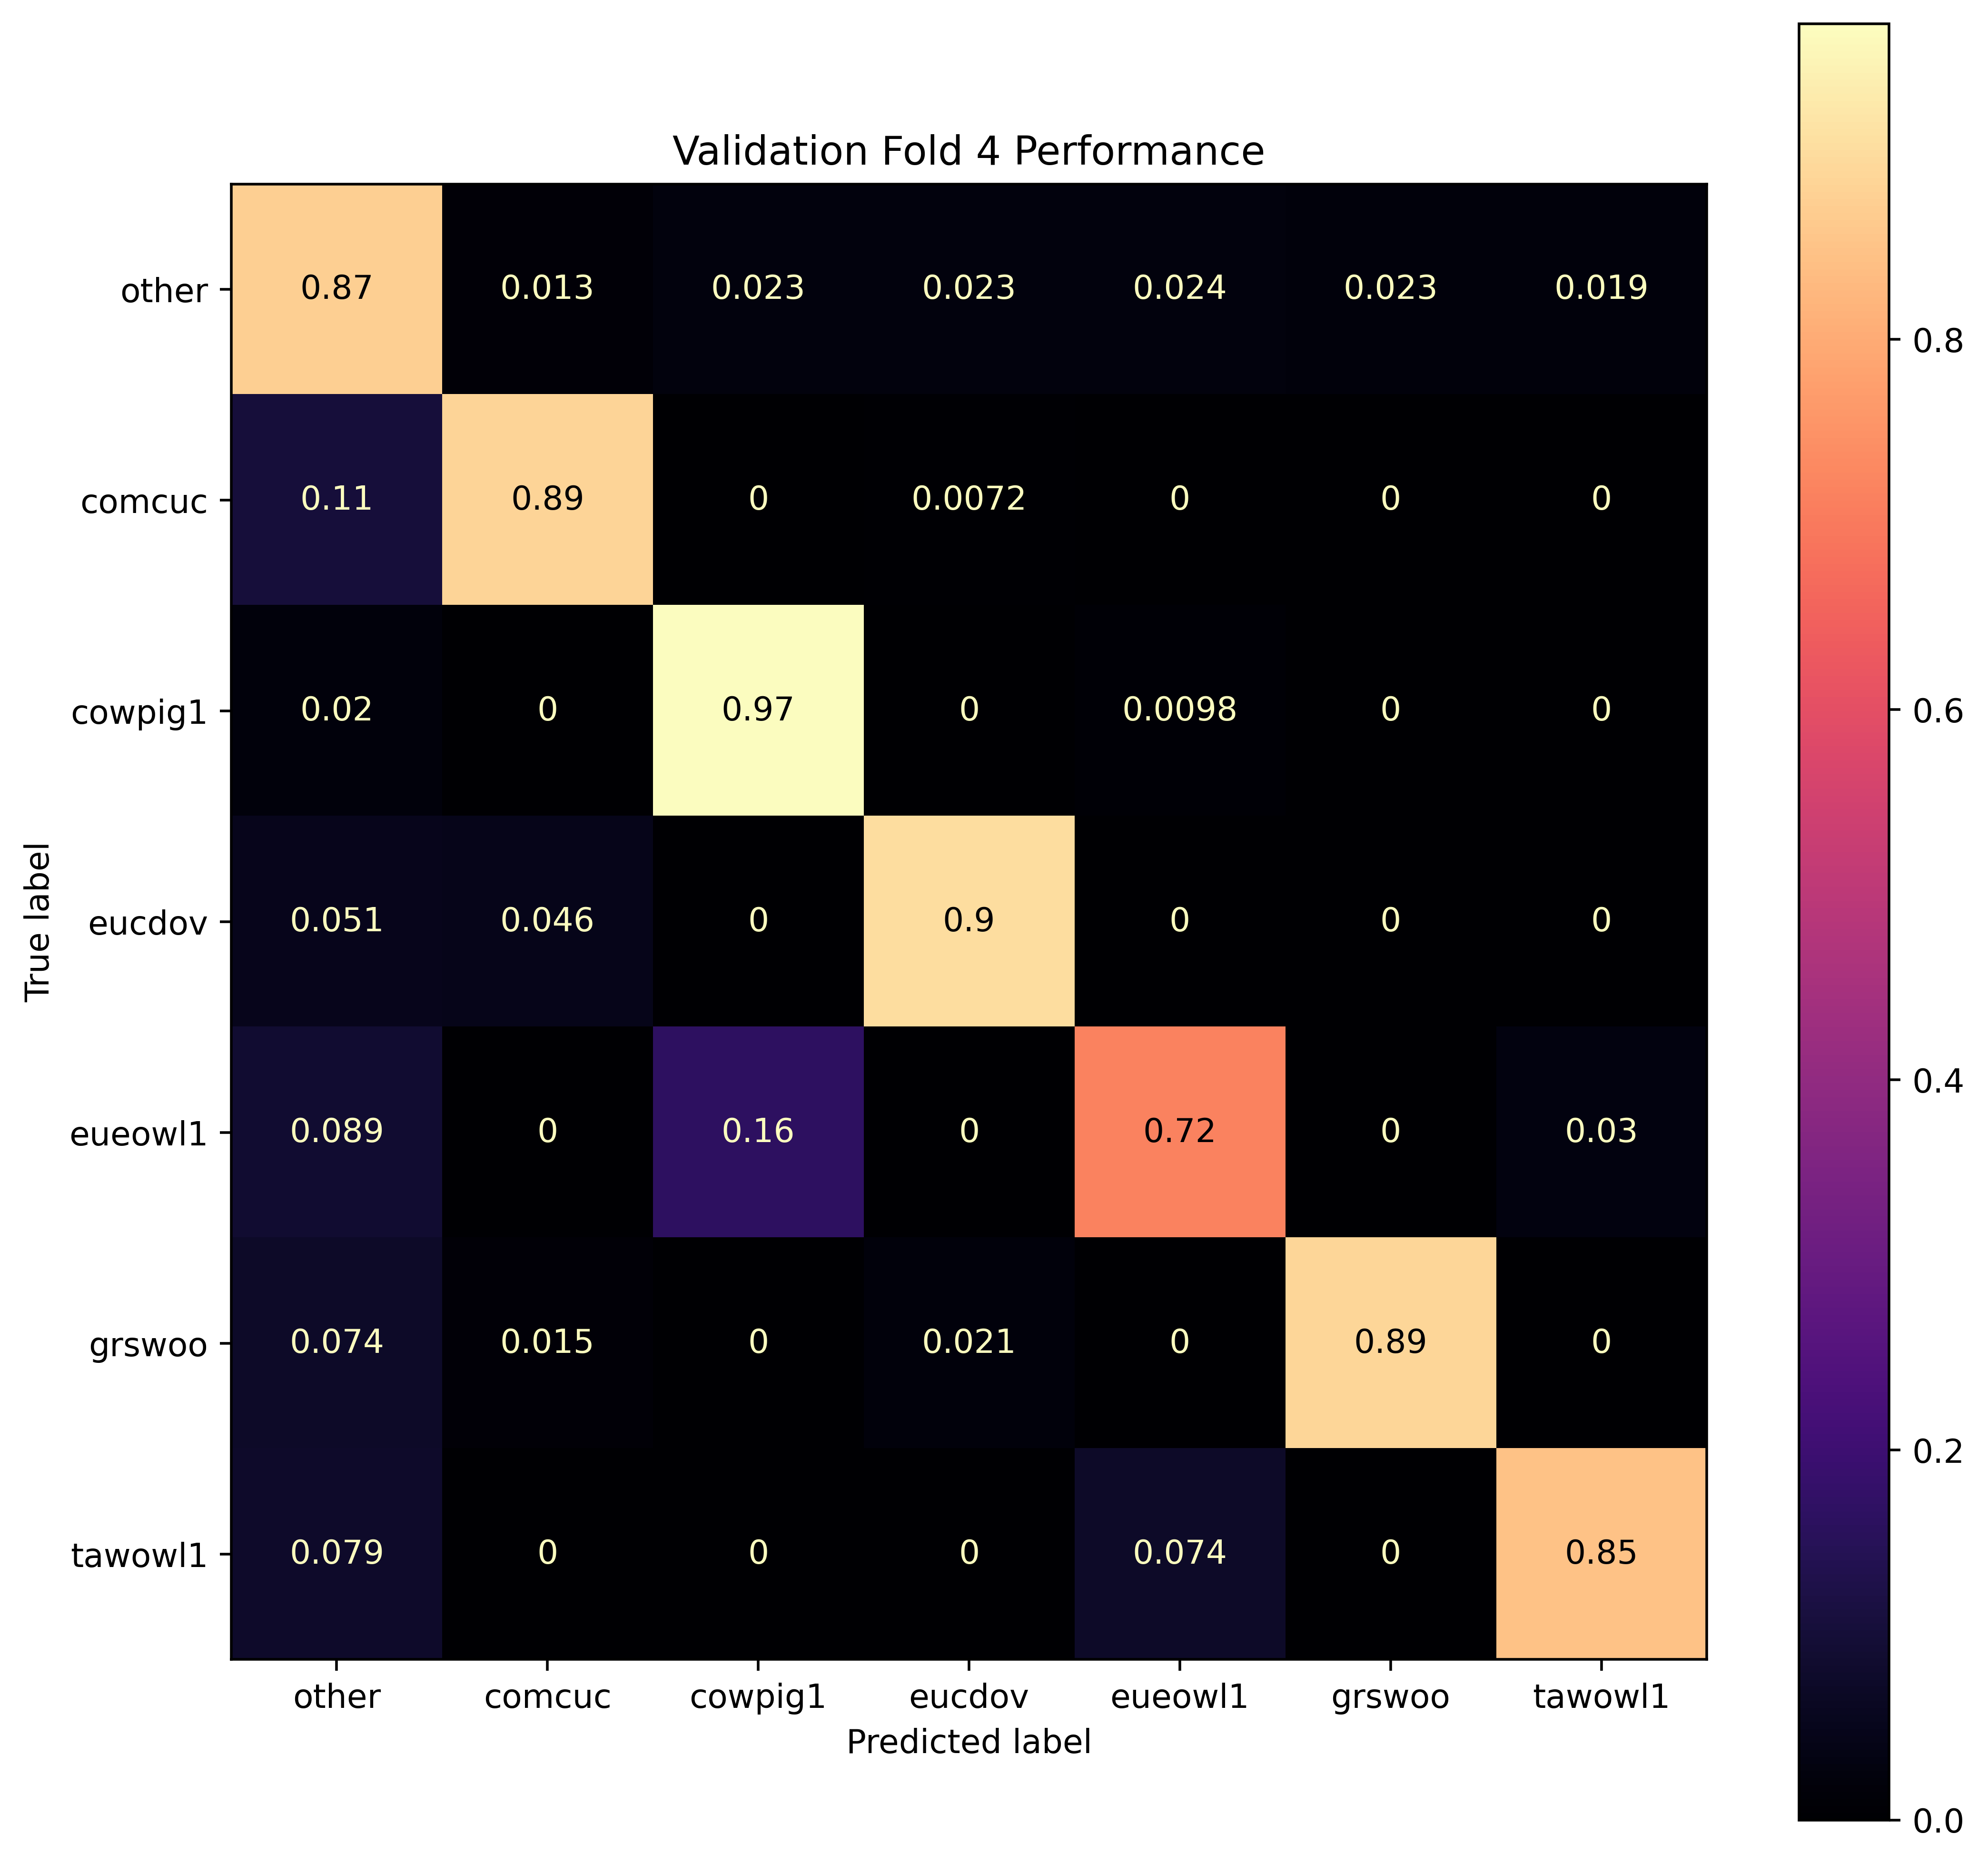

Saved model with scaler as "attention_classifier cv2023-05-17_23.17 fold-4"
Training fold 5
Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 15.1535,  9.3891, 10.5016, 34.7896, 17.2970, 19.8349],
       device='cuda:0')
Training Epoch   0/50 : lr = 0.01, avg_loss = 0.000509, num_samples = 86400, num_correct = 14465, acc = 0.167419, bacc = 0.251406
Evaluation Epoch   0/50 : avg_loss = 0.000472, num_samples =  9600, num_correct =  2878, acc = 0.299792, bacc = 0.486283
Training Epoch   1/50 : lr = 0.01, avg_loss = 0.000275, num_samples = 86400, num_correct = 32808, acc = 0.379722, bacc = 0.663868
Evaluation Epoch   1/50 : avg_loss = 0.000345, num_samples =  9600, num_correct =  4298, acc = 0.447708, bacc = 0.676660
Training Epoch   2/50 : lr = 0.01, avg_loss = 0.000204, num_samples = 86400, num_correct = 48058, acc = 0.556227, bacc = 0.761722
Evaluation Epoch   2/50 : avg_loss = 0.000247, num_samples =  9600, num_correct =  6029, acc = 0.628021, bacc = 0.7

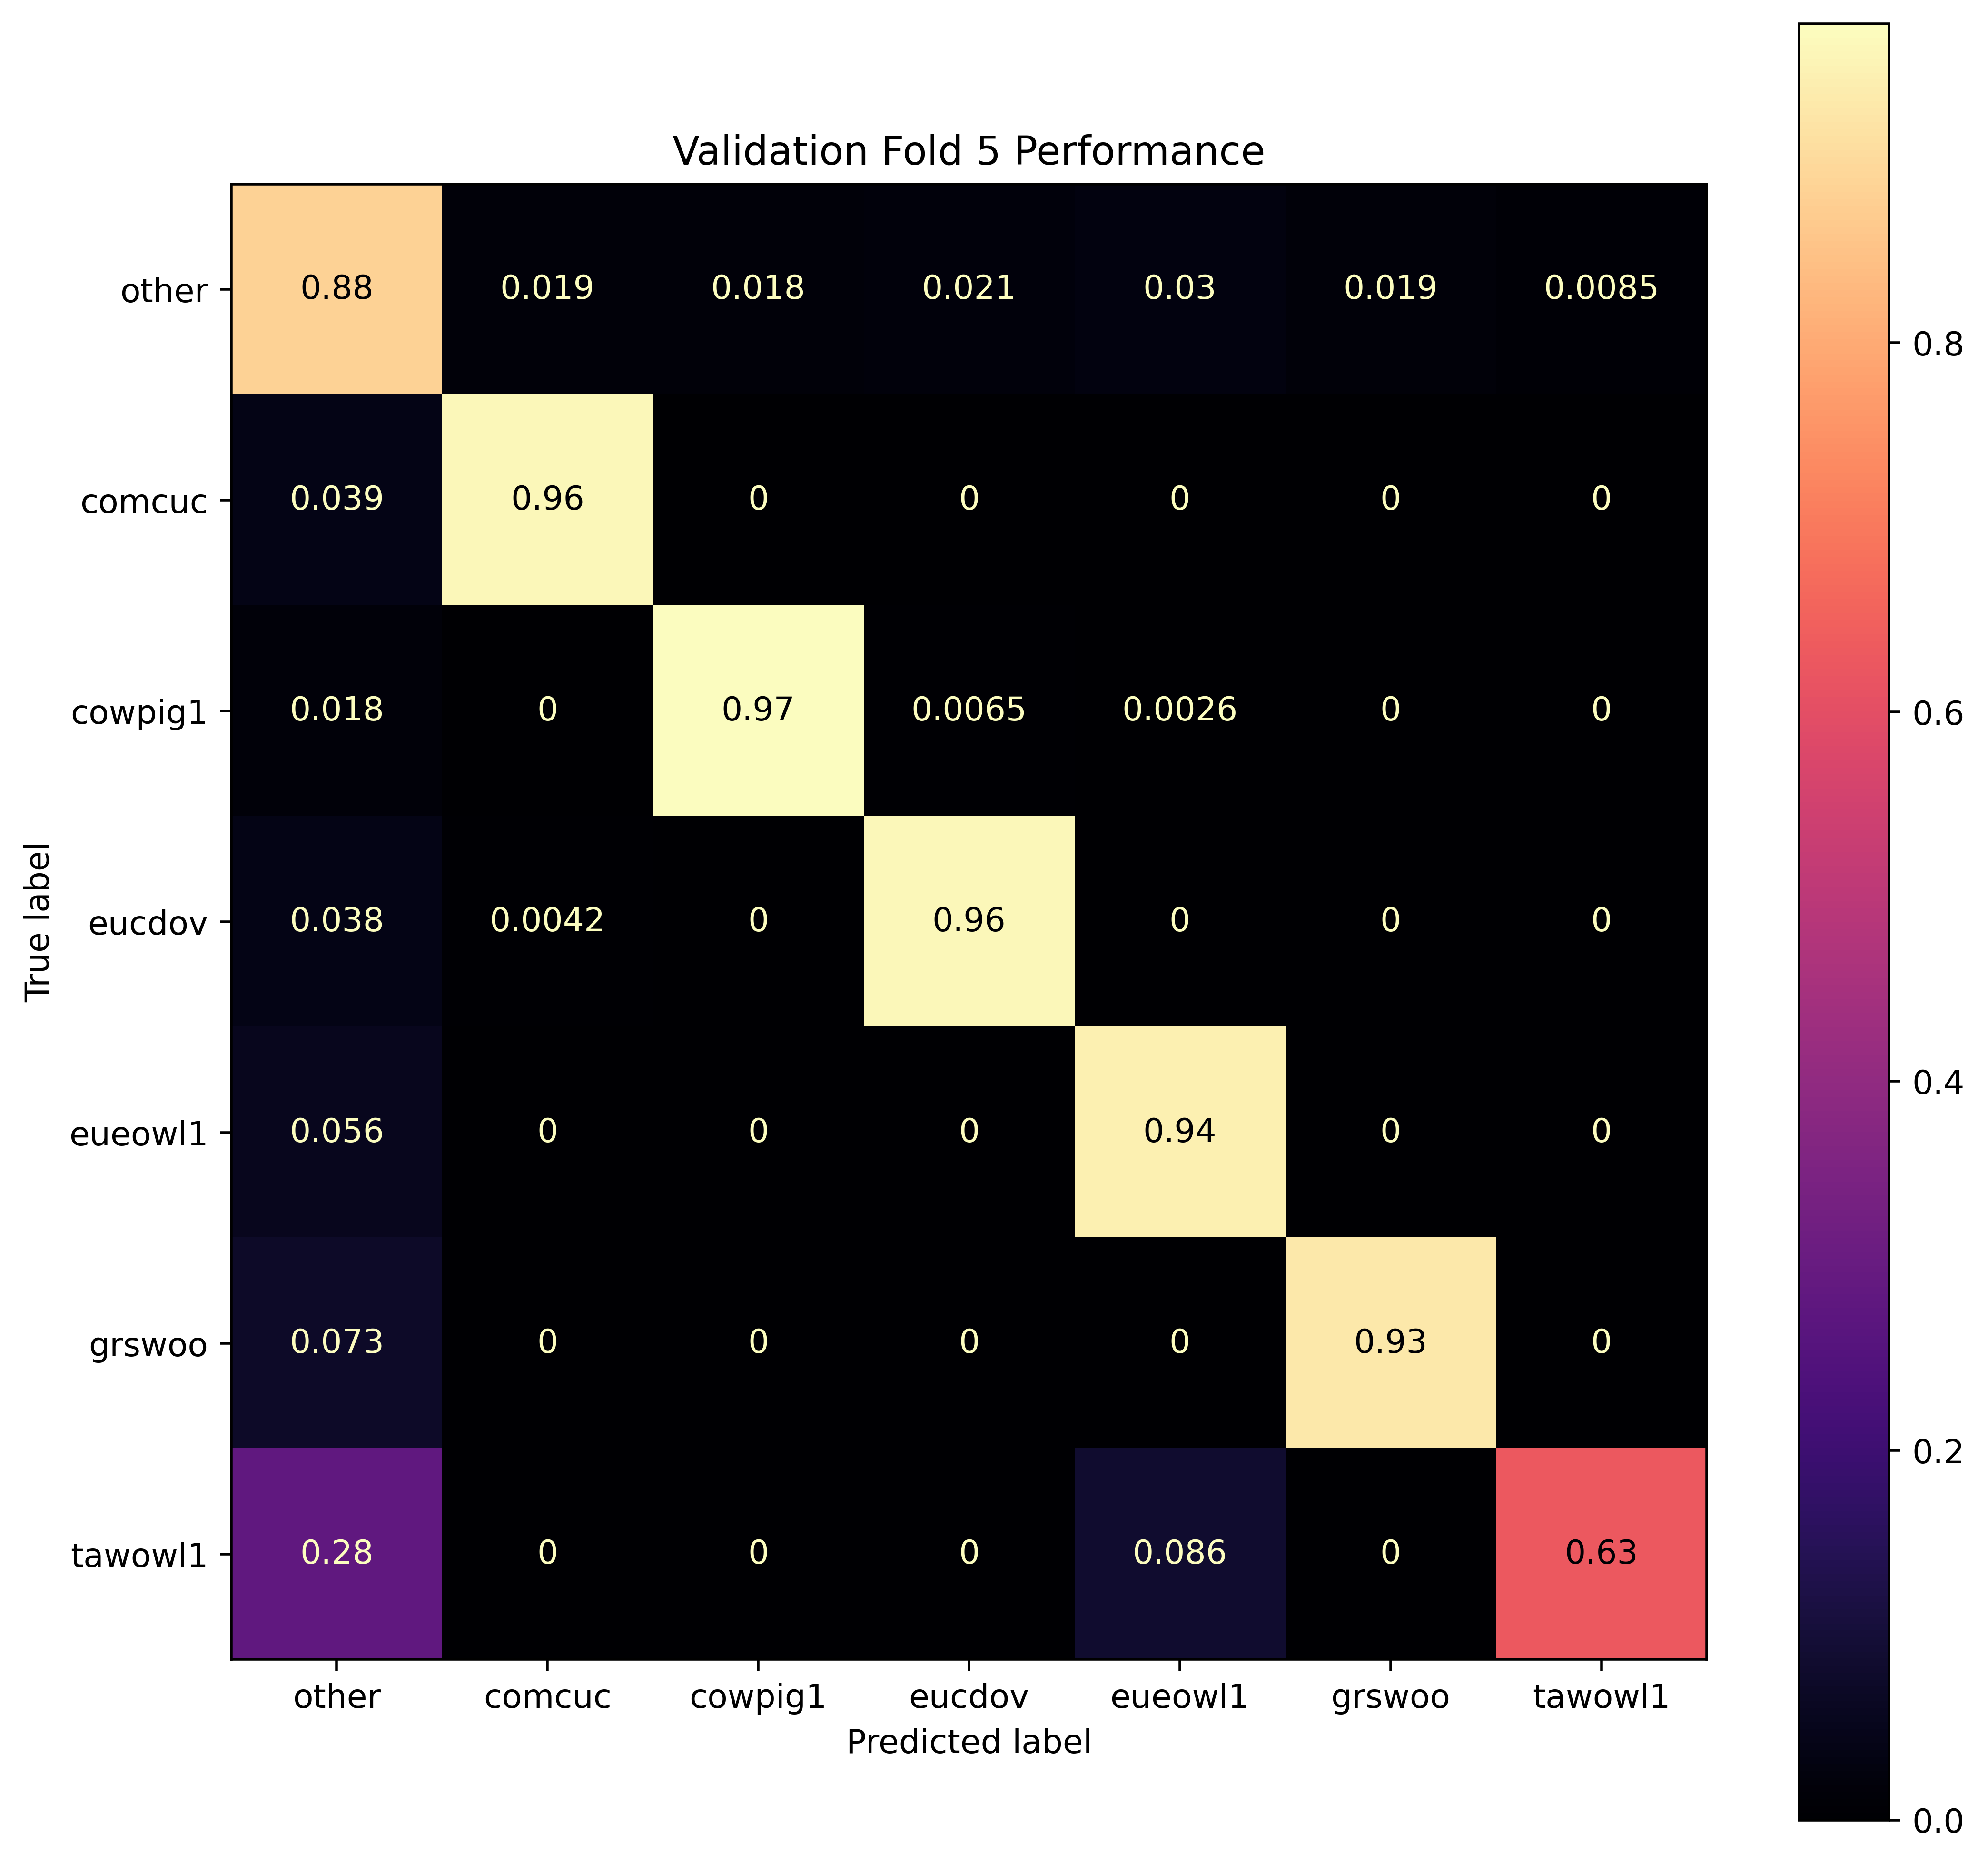

Saved model with scaler as "attention_classifier cv2023-05-17_23.17 fold-5"
Training fold 6
Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 15.5322,  9.7103, 10.4657, 37.7940, 18.6807, 19.9229],
       device='cuda:0')
Training Epoch   0/50 : lr = 0.01, avg_loss = 0.000498, num_samples = 86400, num_correct =  8080, acc = 0.093519, bacc = 0.212265
Evaluation Epoch   0/50 : avg_loss = 0.000460, num_samples =  9600, num_correct =  2173, acc = 0.226354, bacc = 0.382716
Training Epoch   1/50 : lr = 0.01, avg_loss = 0.000328, num_samples = 86400, num_correct = 17236, acc = 0.199491, bacc = 0.529422
Evaluation Epoch   1/50 : avg_loss = 0.000456, num_samples =  9600, num_correct =  2677, acc = 0.278854, bacc = 0.690858
Training Epoch   2/50 : lr = 0.01, avg_loss = 0.000241, num_samples = 86400, num_correct = 26384, acc = 0.305370, bacc = 0.718743
Evaluation Epoch   2/50 : avg_loss = 0.000349, num_samples =  9600, num_correct =  4774, acc = 0.497292, bacc = 0.8

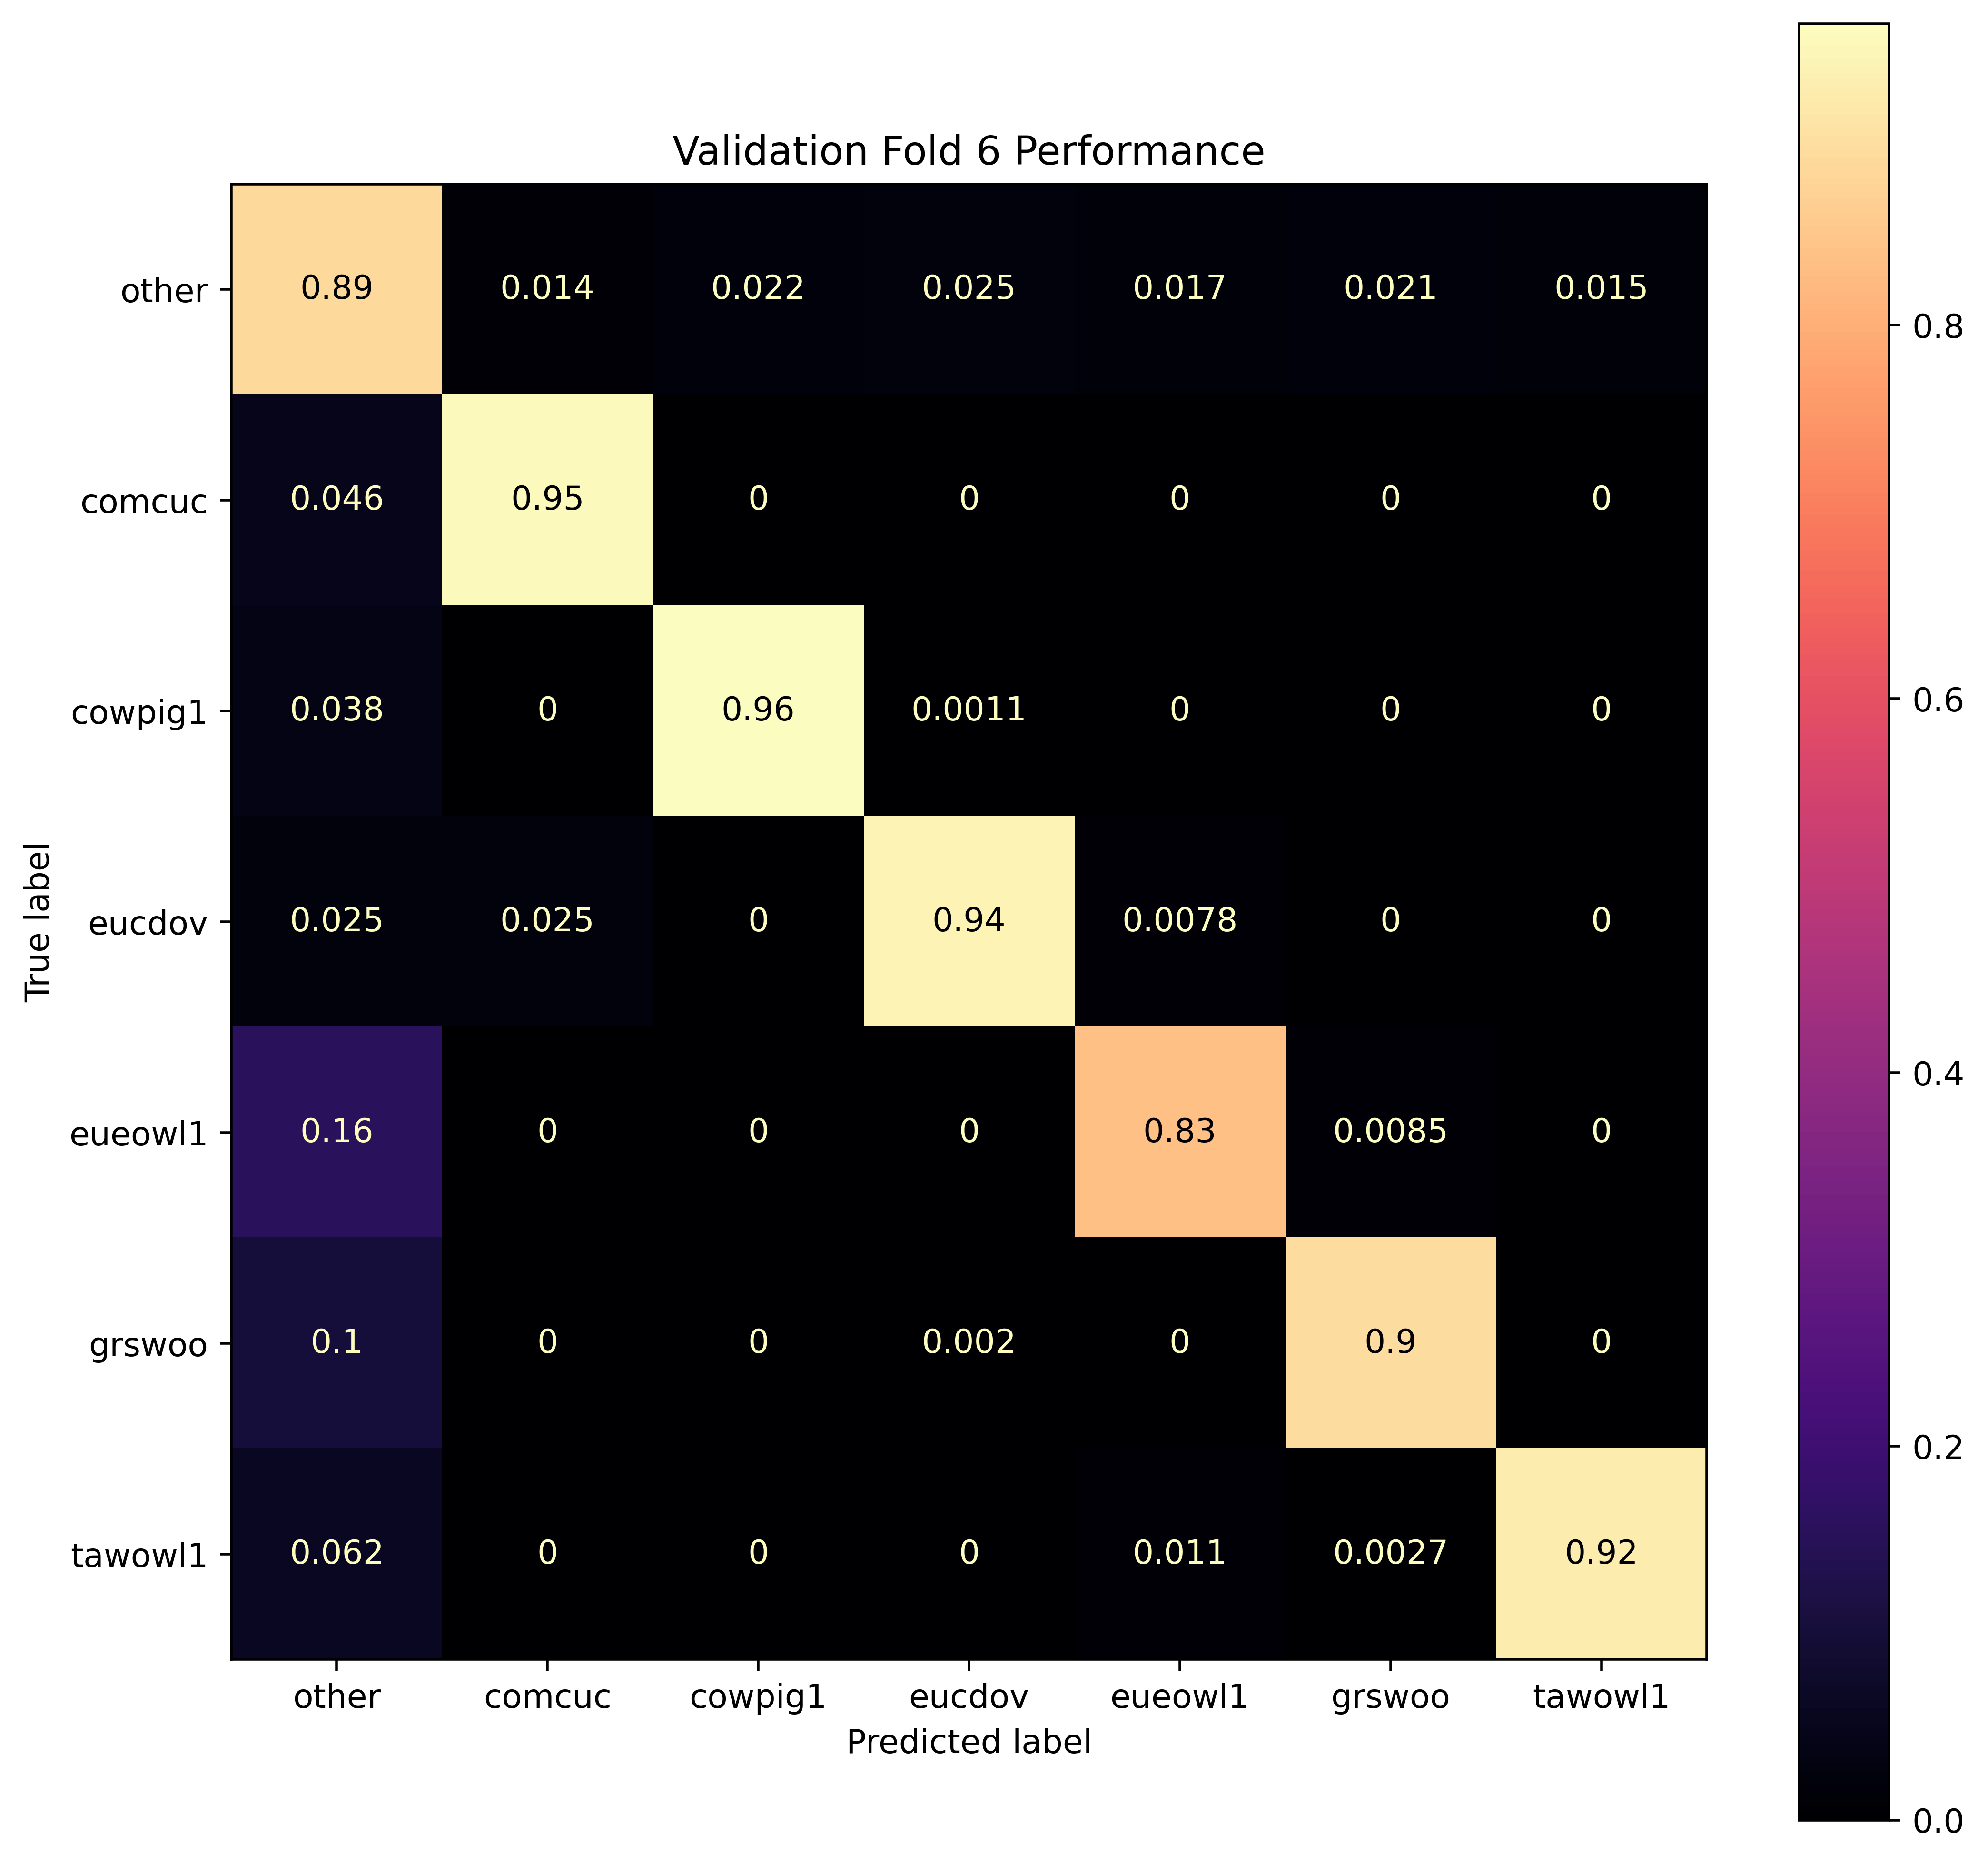

Saved model with scaler as "attention_classifier cv2023-05-17_23.17 fold-6"
Training fold 7
Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 15.2754,  9.2280, 10.5393, 36.0422, 17.5385, 19.9870],
       device='cuda:0')
Training Epoch   0/50 : lr = 0.01, avg_loss = 0.000514, num_samples = 86400, num_correct = 11320, acc = 0.131019, bacc = 0.255095
Evaluation Epoch   0/50 : avg_loss = 0.000496, num_samples =  9600, num_correct =  1981, acc = 0.206354, bacc = 0.582332
Training Epoch   1/50 : lr = 0.01, avg_loss = 0.000295, num_samples = 86400, num_correct = 20845, acc = 0.241262, bacc = 0.607515
Evaluation Epoch   1/50 : avg_loss = 0.000487, num_samples =  9600, num_correct =  2596, acc = 0.270417, bacc = 0.705197
Training Epoch   2/50 : lr = 0.01, avg_loss = 0.000213, num_samples = 86400, num_correct = 31448, acc = 0.363981, bacc = 0.738787
Evaluation Epoch   2/50 : avg_loss = 0.000442, num_samples =  9600, num_correct =  4677, acc = 0.487187, bacc = 0.7

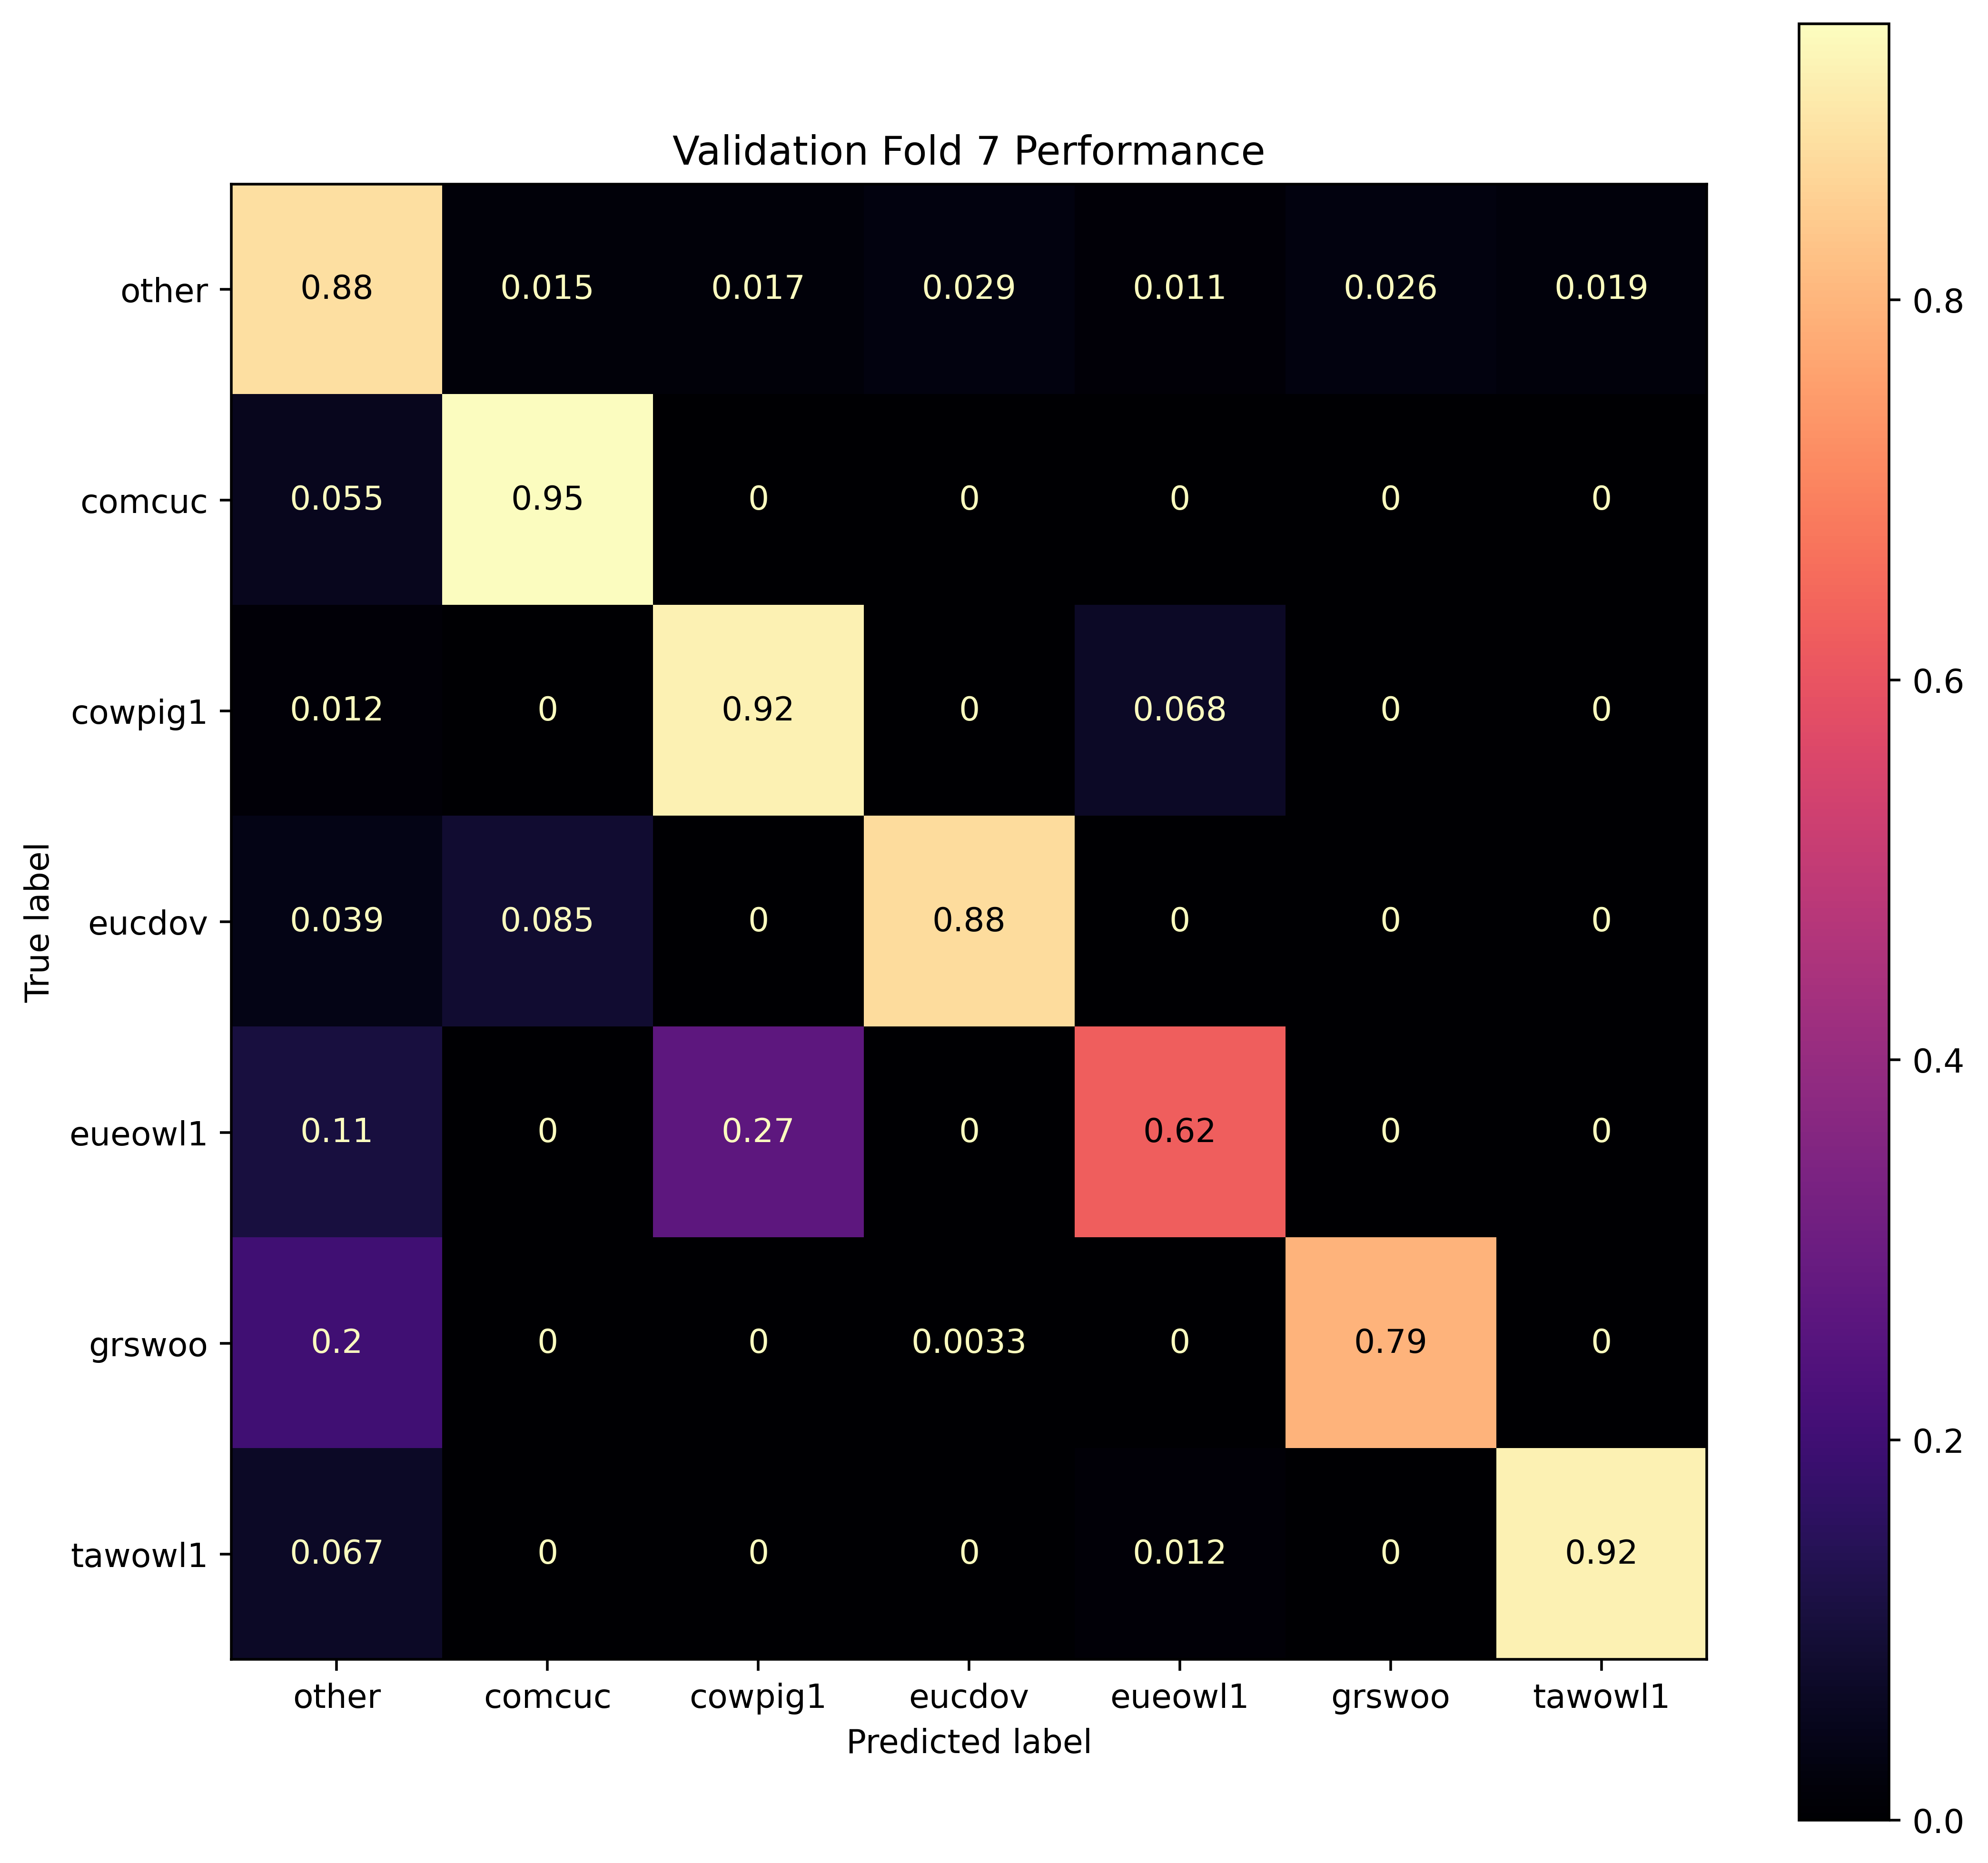

Saved model with scaler as "attention_classifier cv2023-05-17_23.17 fold-7"
Training fold 8
Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 14.8754,  9.0629, 10.1272, 34.8762, 17.6241, 19.4274],
       device='cuda:0')
Training Epoch   0/50 : lr = 0.01, avg_loss = 0.000514, num_samples = 86400, num_correct = 11108, acc = 0.128565, bacc = 0.257105
Evaluation Epoch   0/50 : avg_loss = 0.000517, num_samples =  9600, num_correct =  1540, acc = 0.160417, bacc = 0.558575
Training Epoch   1/50 : lr = 0.01, avg_loss = 0.000289, num_samples = 86400, num_correct = 22994, acc = 0.266134, bacc = 0.632751
Evaluation Epoch   1/50 : avg_loss = 0.000366, num_samples =  9600, num_correct =  3799, acc = 0.395729, bacc = 0.787926
Training Epoch   2/50 : lr = 0.01, avg_loss = 0.000178, num_samples = 86400, num_correct = 47774, acc = 0.552940, bacc = 0.793276
Evaluation Epoch   2/50 : avg_loss = 0.000297, num_samples =  9600, num_correct =  5974, acc = 0.622292, bacc = 0.8

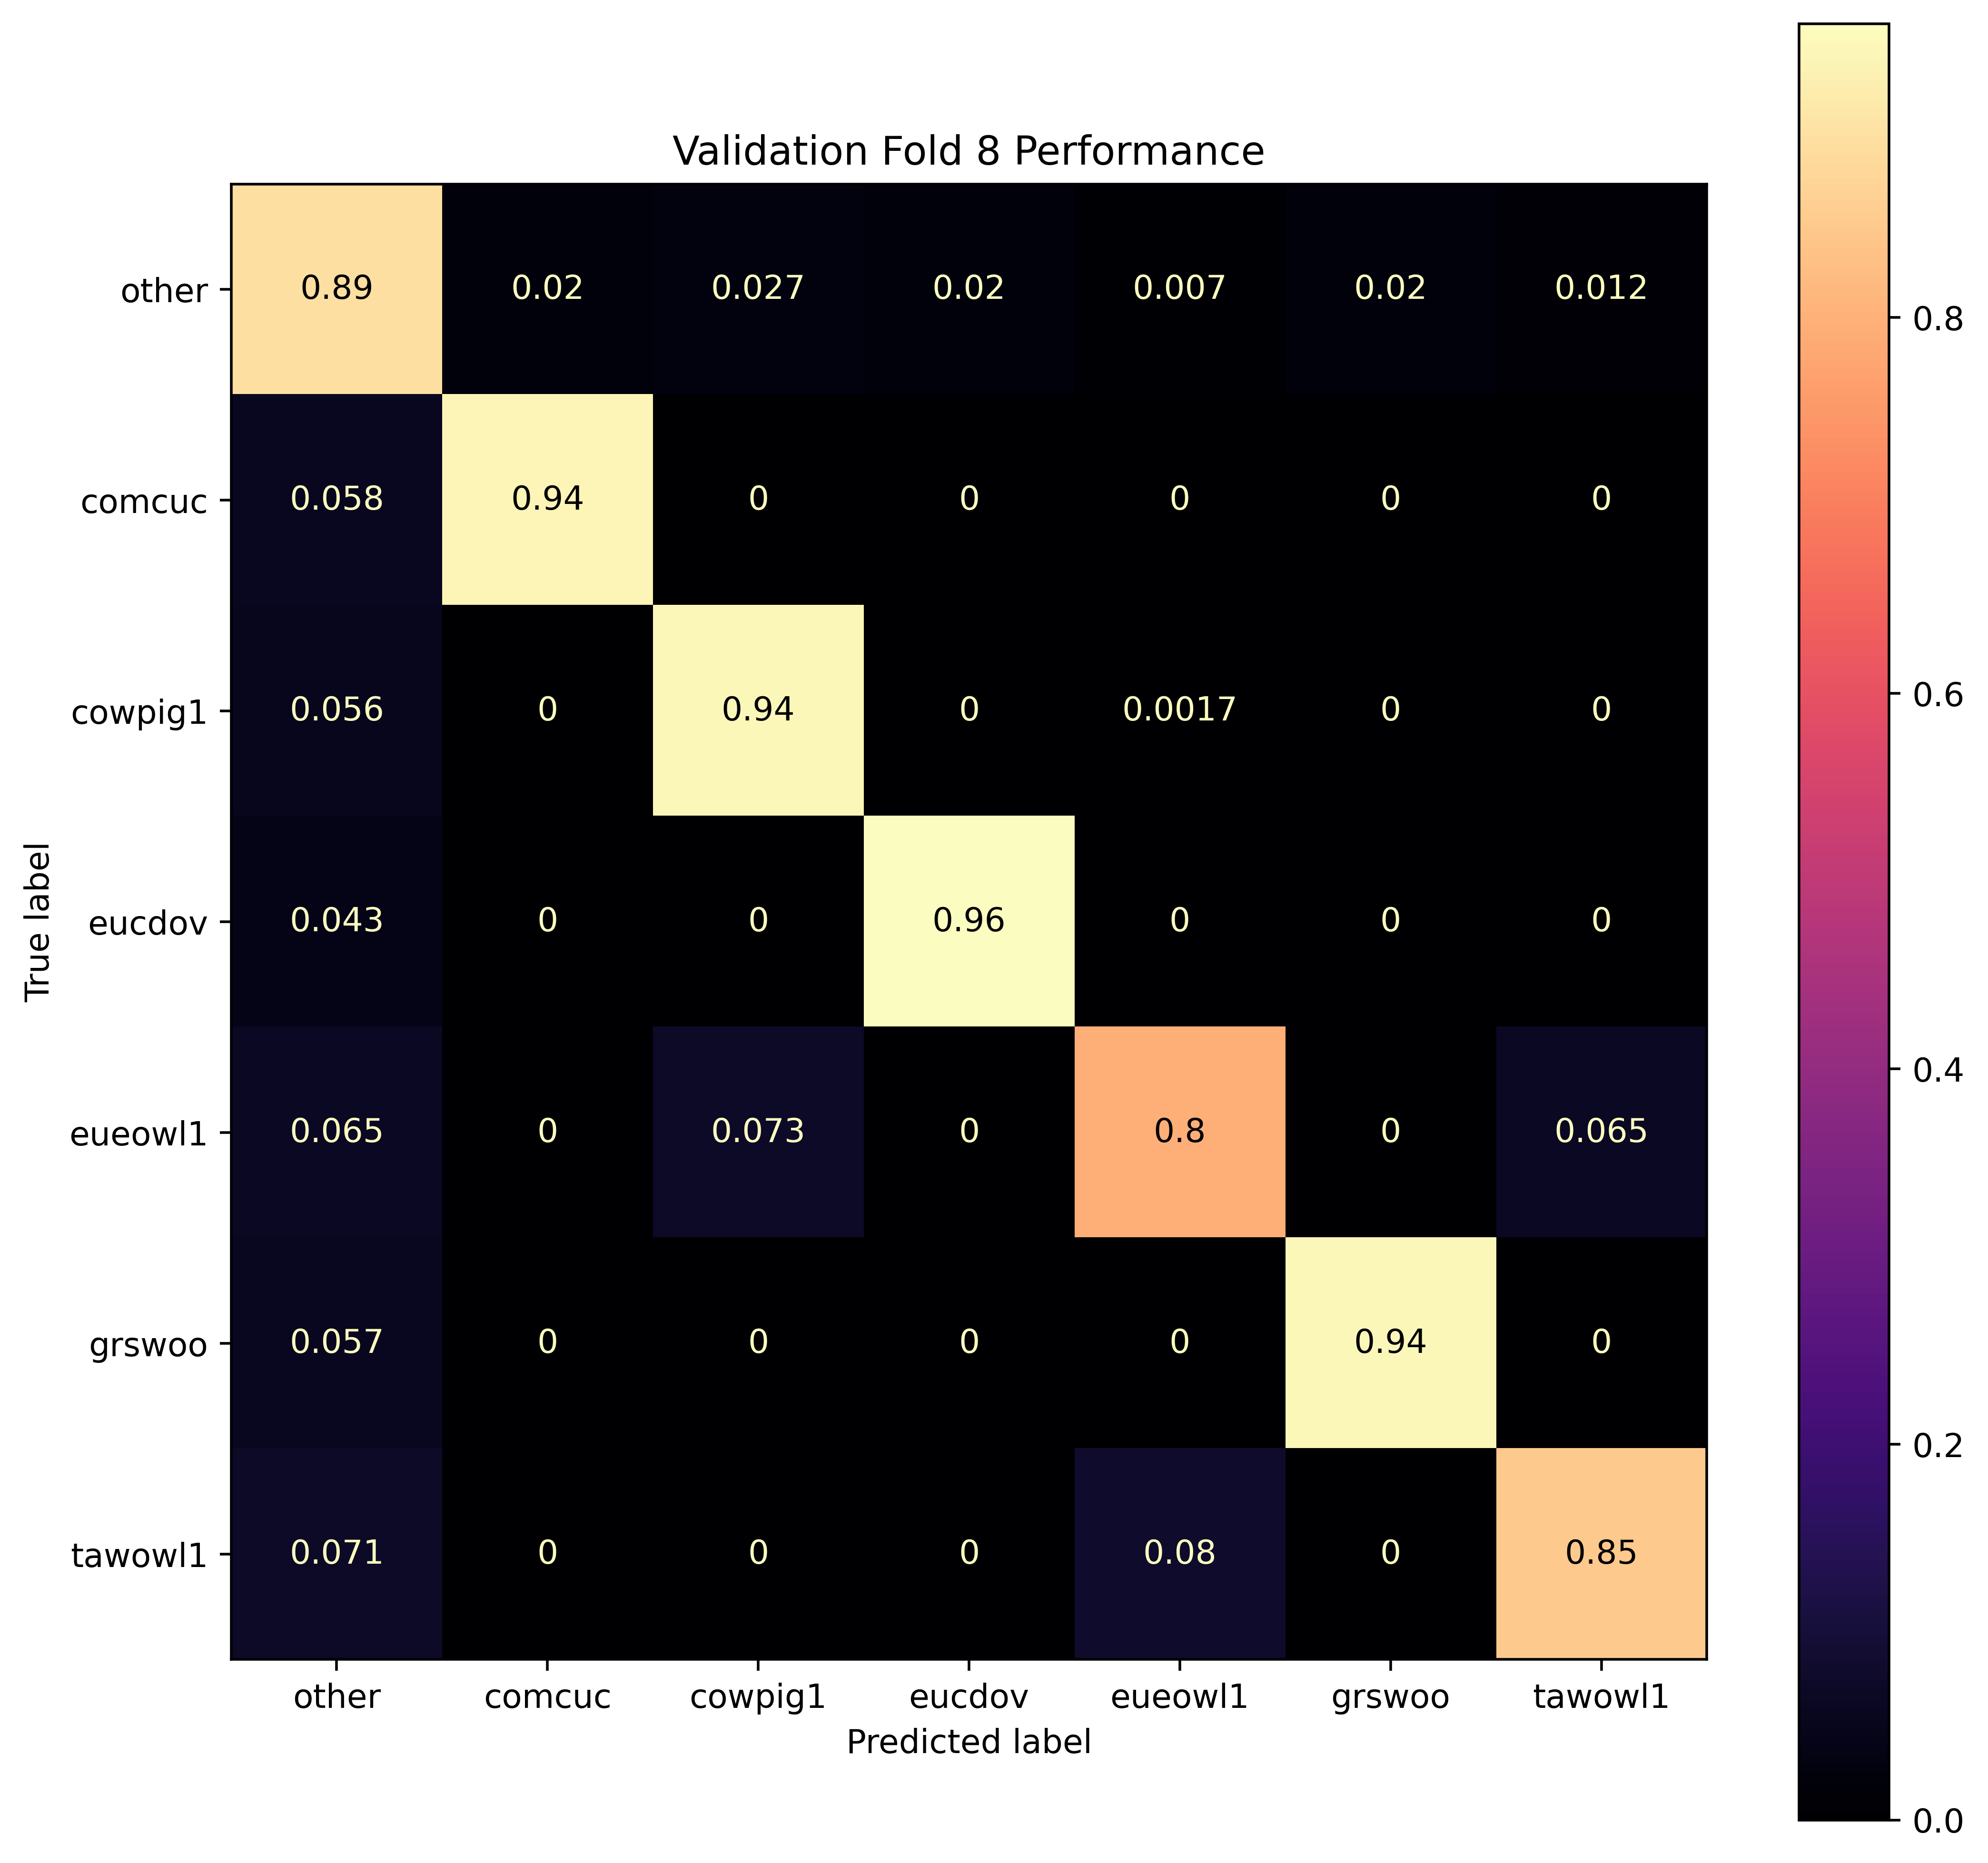

Saved model with scaler as "attention_classifier cv2023-05-17_23.17 fold-8"
Training fold 9
Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 15.2223,  9.4648, 10.3051, 37.4453, 18.2622, 19.2489],
       device='cuda:0')
Training Epoch   0/50 : lr = 0.01, avg_loss = 0.000504, num_samples = 86400, num_correct = 11997, acc = 0.138854, bacc = 0.268987
Evaluation Epoch   0/50 : avg_loss = 0.000439, num_samples =  9600, num_correct =  3141, acc = 0.327188, bacc = 0.521880
Training Epoch   1/50 : lr = 0.01, avg_loss = 0.000329, num_samples = 86400, num_correct = 24605, acc = 0.284780, bacc = 0.541045
Evaluation Epoch   1/50 : avg_loss = 0.000320, num_samples =  9600, num_correct =  4545, acc = 0.473438, bacc = 0.643210
Training Epoch   2/50 : lr = 0.01, avg_loss = 0.000227, num_samples = 86400, num_correct = 34851, acc = 0.403368, bacc = 0.707128
Evaluation Epoch   2/50 : avg_loss = 0.000310, num_samples =  9600, num_correct =  5363, acc = 0.558646, bacc = 0.7

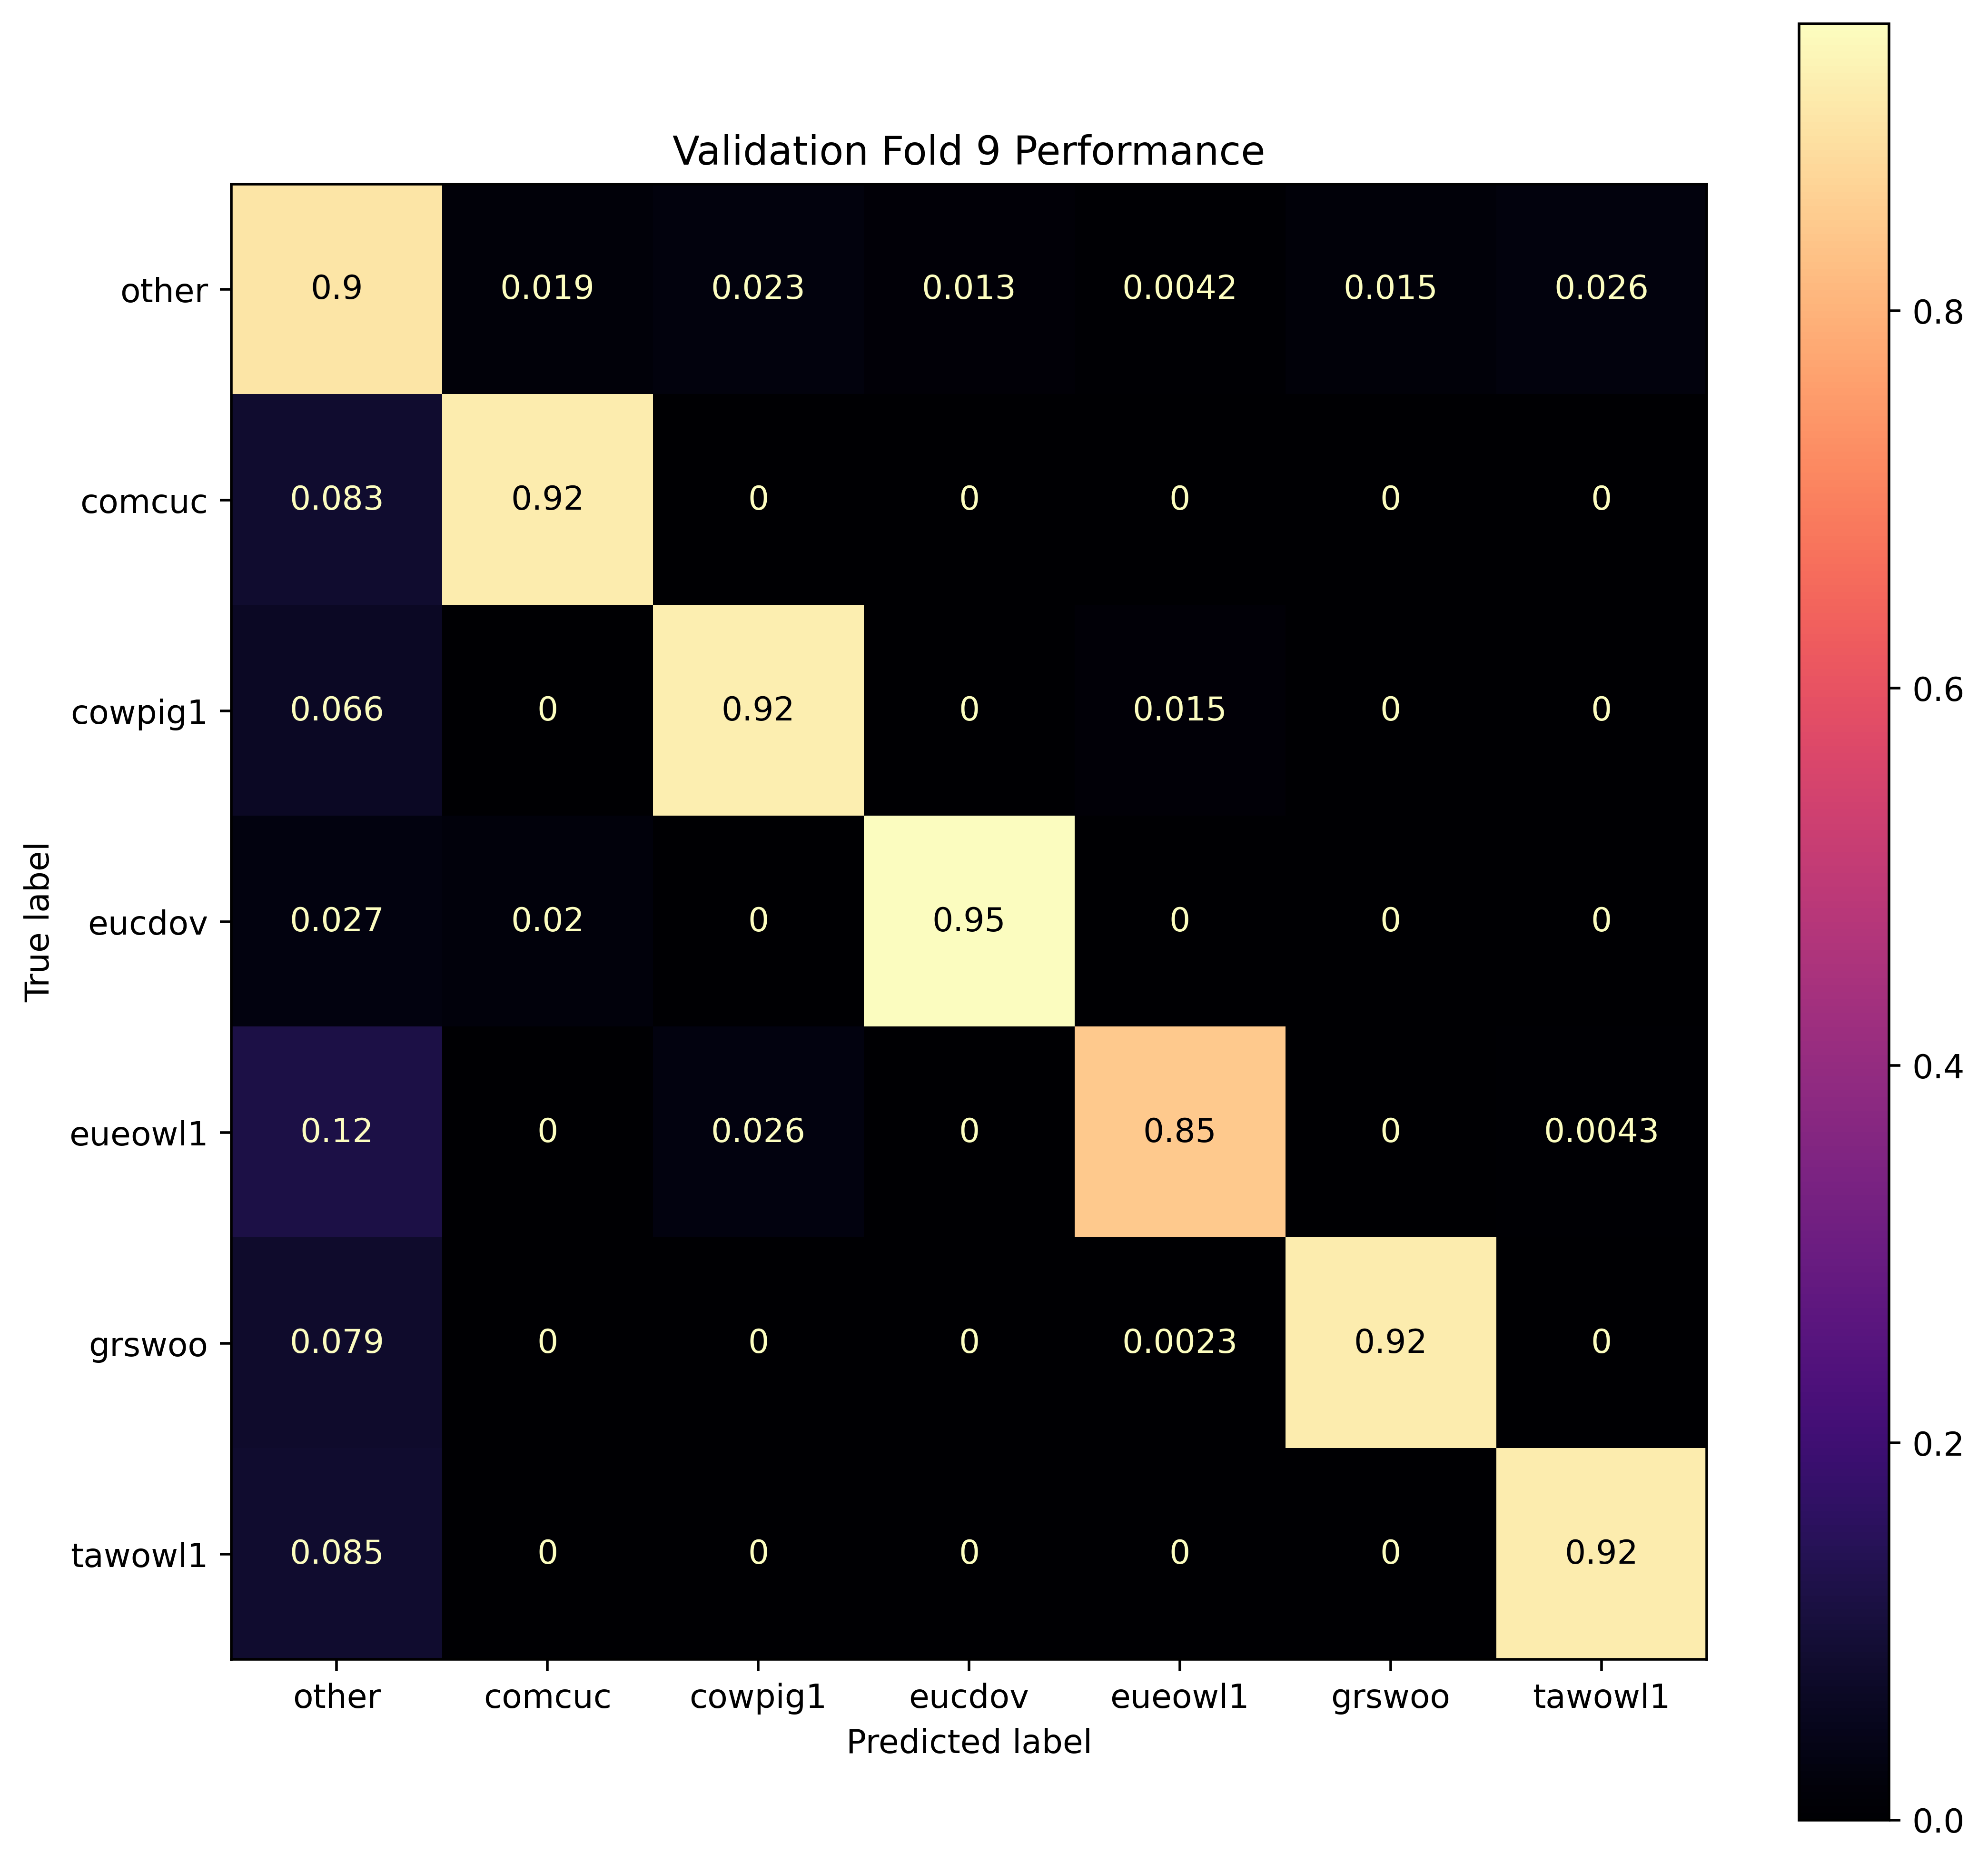

Saved model with scaler as "attention_classifier cv2023-05-17_23.17 fold-9"


In [65]:
set_random_seed(42)

cv_training_hyper_parameters = create_training_hyper_parameters(0.5)

cv_models_with_scalers, cv_folds_metrics = train_attention_classifier_with_cv(
    hyper_parameters, 
    cv_training_hyper_parameters, 
    NumpyDataset(data_train, labels_train),
    device
)

In [66]:
cv_final_epoch_avg_train_metrics, cv_final_epoch_avg_evaluation_metrics = calculate_average_metrics_for_final_epoch_of_folds(cv_folds_metrics)
print(f'{cv_final_epoch_avg_train_metrics      = }')
print(f'{cv_final_epoch_avg_evaluation_metrics = }')

cv_avg_epoch_train_metrics = calculate_average_metrics_per_epoch(cv_folds_metrics)
# for epoch_nr, (epoch_train_metrics, epoch_eval_metrics) in enumerate(cv_avg_epoch_train_metrics):
#     print(f'Train Epoch {epoch_nr}: {epoch_train_metrics}')
#     if epoch_eval_metrics is not None:
#         print(f'Validation Epoch {epoch_nr}: {epoch_eval_metrics}')

cv_final_epoch_avg_train_metrics      = avg_loss = 0.000019, num_samples = 86400, num_correct = 80084.100000, acc = 0.926899, bacc = 0.982558
cv_final_epoch_avg_evaluation_metrics = avg_loss = 0.008989, num_samples =  9600, num_correct = 8469.600000, acc = 0.882250, bacc = 0.881028


## Final Train/Test

Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 15.3204,  9.3547, 10.4259, 36.4963, 17.9374, 19.6462],
       device='cuda:0')
Training Epoch   0/75 : lr = 0.01, avg_loss = 0.000613, num_samples = 96000, num_correct = 15110, acc = 0.157396, bacc = 0.191223
Evaluation Epoch   0/75 : avg_loss = 0.000832, num_samples = 24000, num_correct =   879, acc = 0.036625, bacc = 0.144058
Training Epoch   1/75 : lr = 0.01, avg_loss = 0.000831, num_samples = 96000, num_correct =  6952, acc = 0.072417, bacc = 0.164271
Evaluation Epoch   1/75 : avg_loss = 0.000770, num_samples = 24000, num_correct =  5482, acc = 0.228417, bacc = 0.125089
Training Epoch   2/75 : lr = 0.01, avg_loss = 0.000615, num_samples = 96000, num_correct = 10984, acc = 0.114417, bacc = 0.227866
Evaluation Epoch   2/75 : avg_loss = 0.001019, num_samples = 24000, num_correct =   606, acc = 0.025250, bacc = 0.117465
Training Epoch   3/75 : lr = 0.01, avg_loss = 0.000746, num_samples = 96000, num_corre

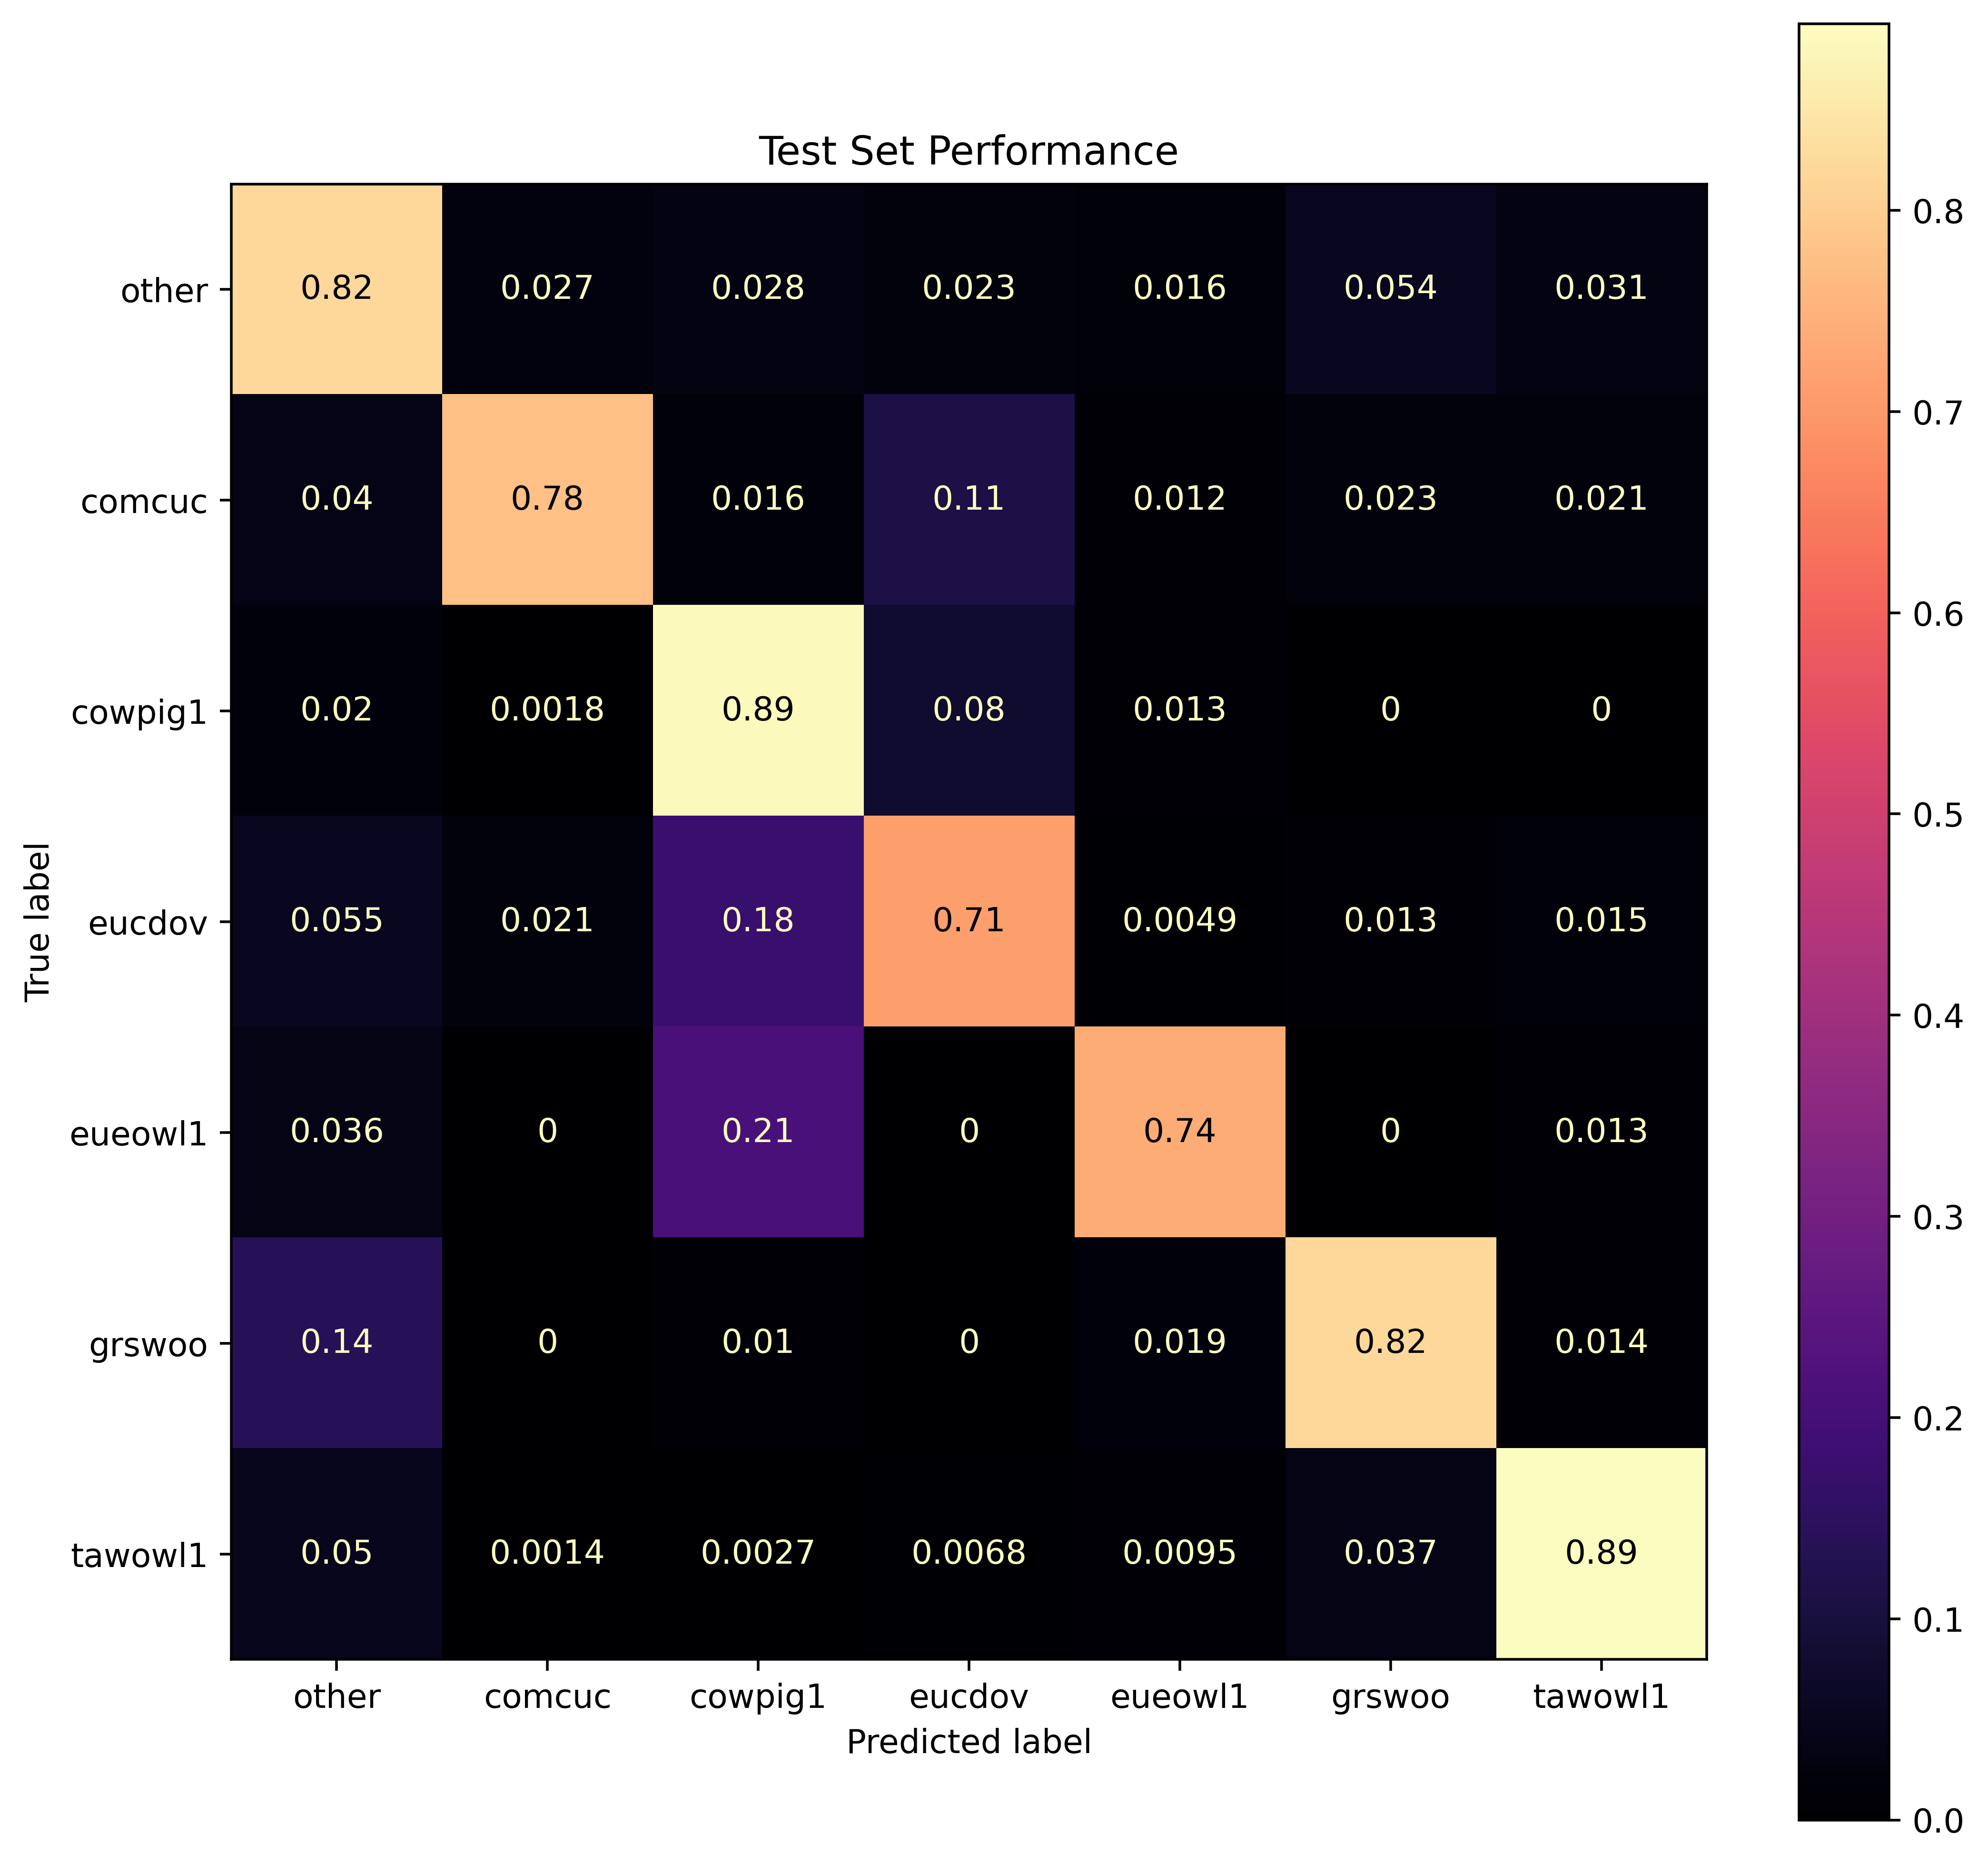

training_run_metrics[-1][0] = avg_loss = 0.000036, num_samples = 96000, num_correct = 83776, acc = 0.872667, bacc = 0.964131
test_metrics                = avg_loss = 0.000230, num_samples = 24000, num_correct = 19597, acc = 0.816542, bacc = 0.806975


In [70]:
set_random_seed(41)

final_training_hyper_parameters = create_training_hyper_parameters(0.5)

data_train_normalized, data_test_normalized, normalization_scaler = normalize_data(data_train, data_test)

attention_classifier, training_run_metrics = train_attention_classifier(
    hyper_parameters, 
    final_training_hyper_parameters, 
    NumpyDataset(data_train_normalized, labels_train),
    NumpyDataset(data_test_normalized, labels_test),
    device
)

test_loader = create_data_loader(data_test_normalized, labels_test)
test_metrics = evaluate_attention_classifier(
    attention_classifier, 
    test_loader, 
    device, 
    show_confmat = True,
    confmat_title = 'Test Set Performance'
)

print(f'{training_run_metrics[-1][0] = }')
print(f'{test_metrics                = }')

# Plots

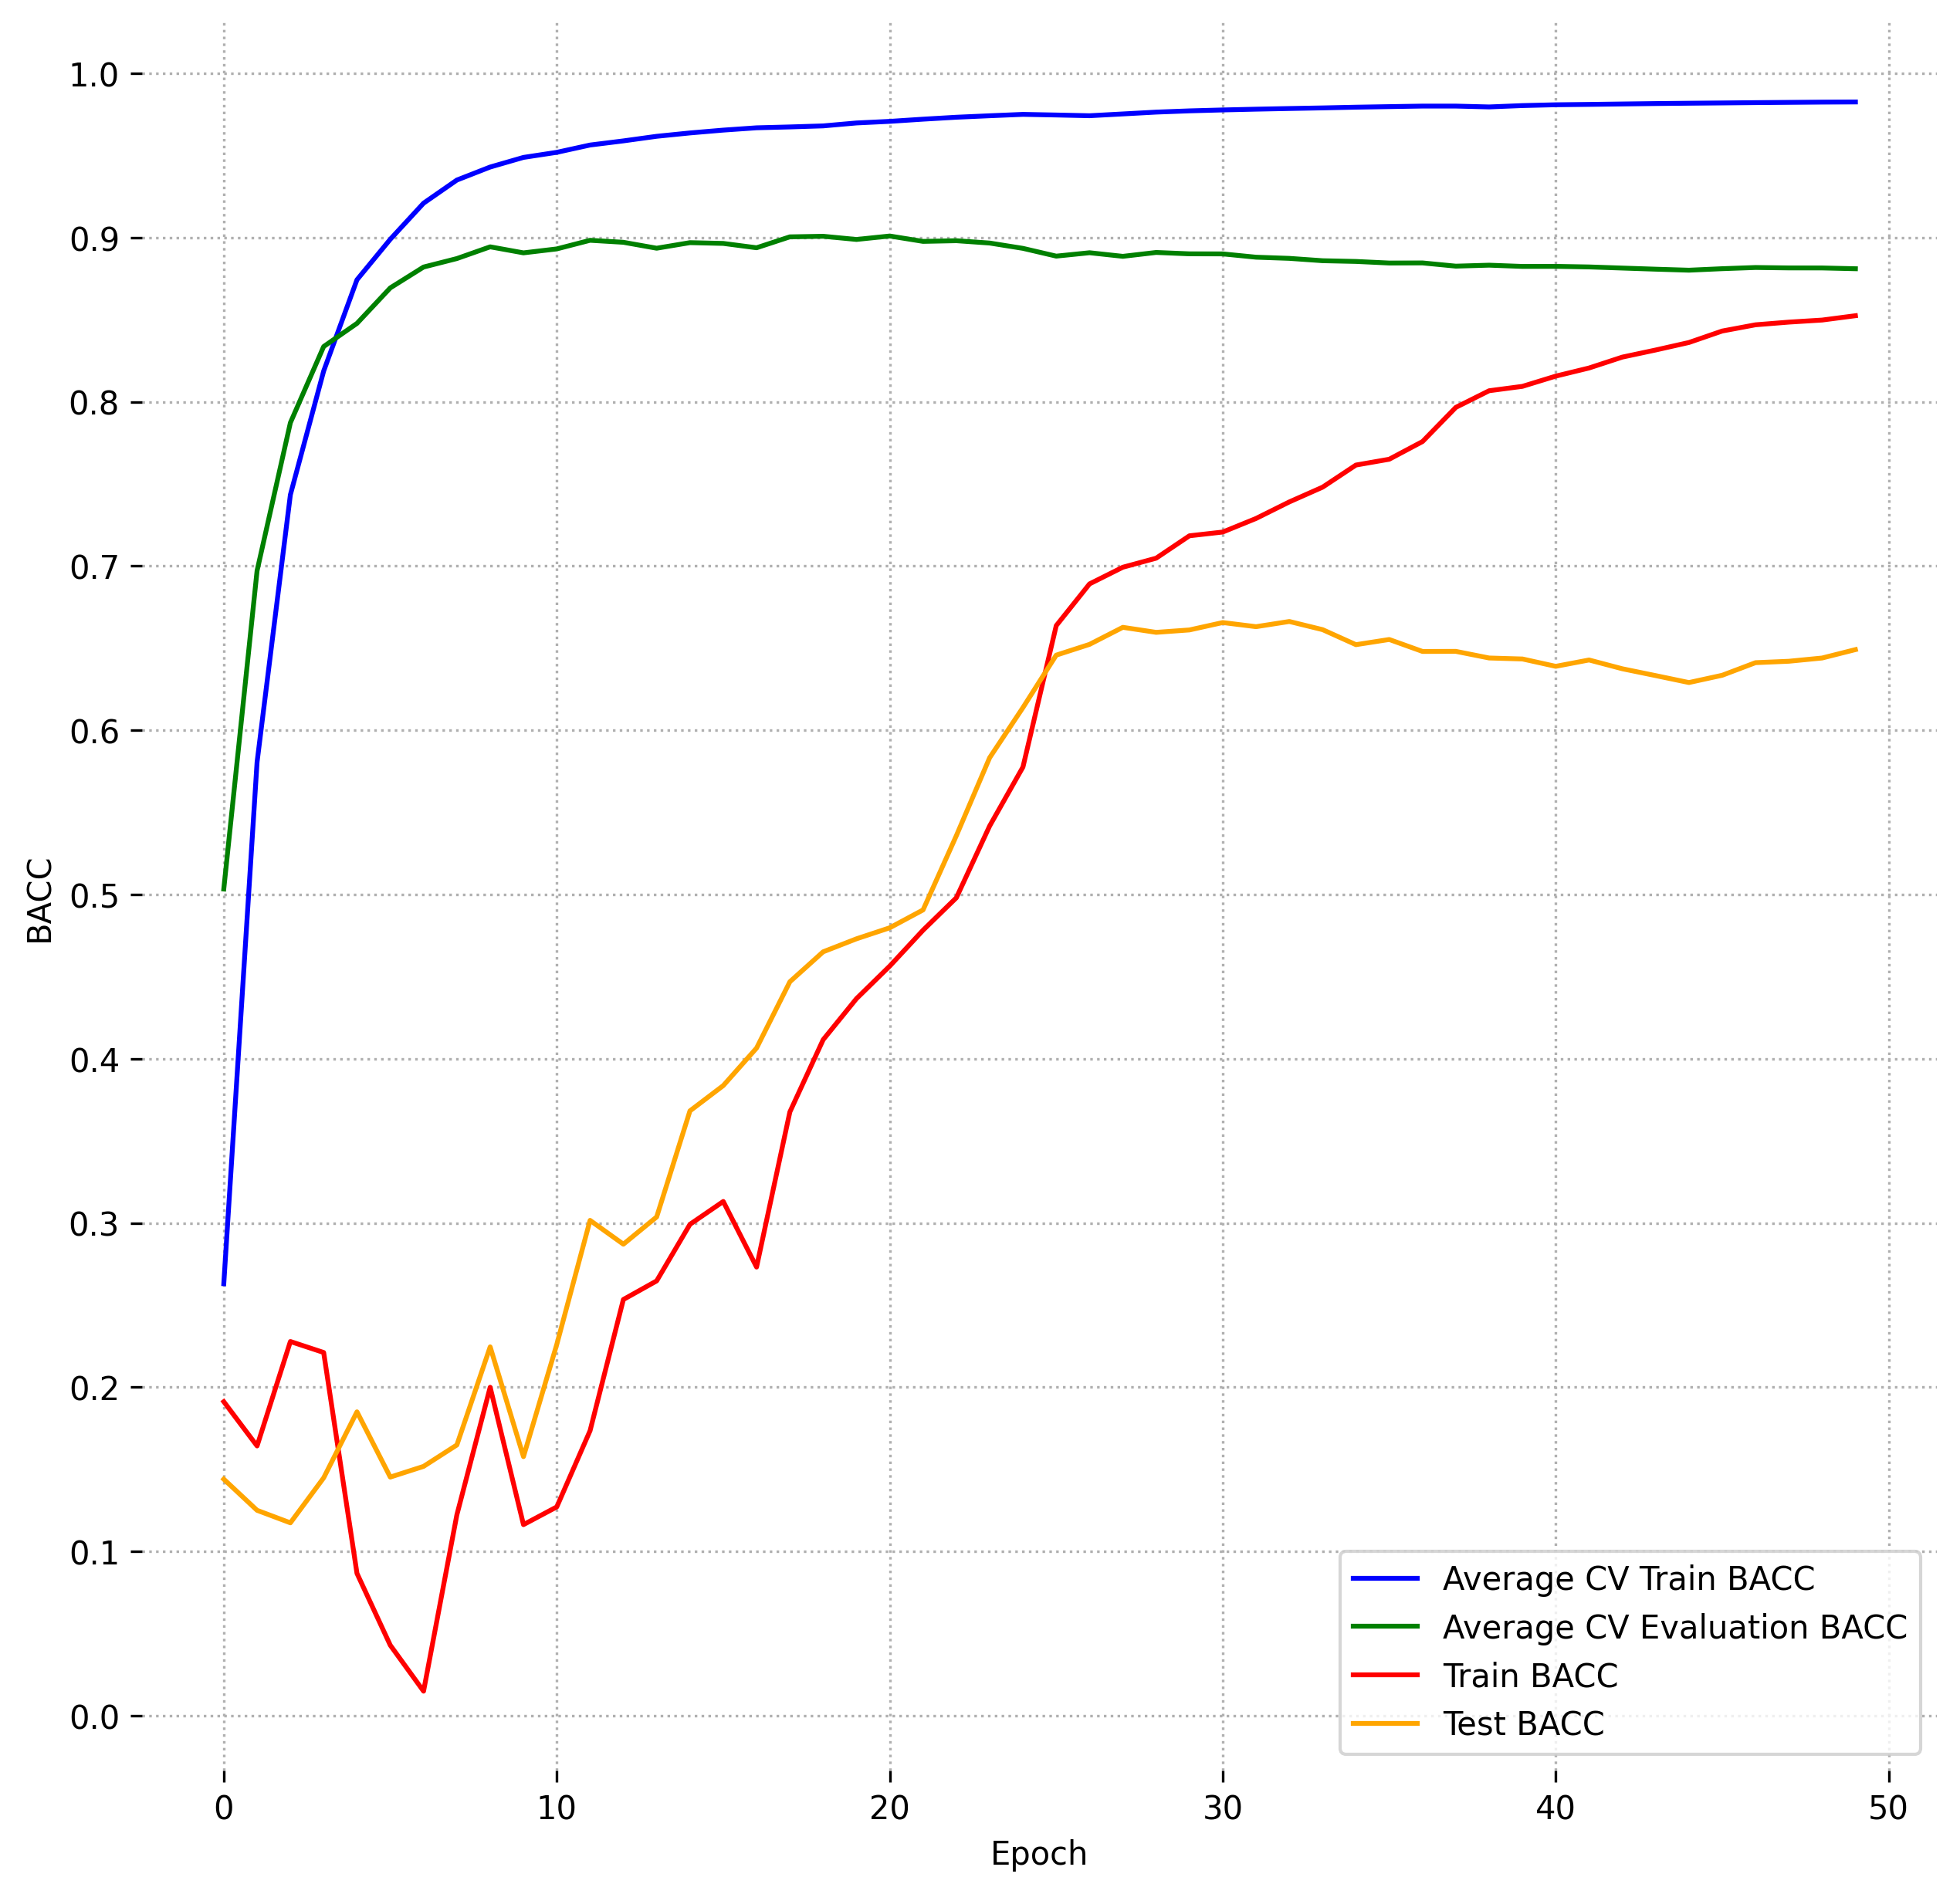

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300)

epoch_range = np.arange(0, len(cv_avg_epoch_train_metrics))

ax.plot(epoch_range, list(map(lambda m: m[0].bacc, cv_avg_epoch_train_metrics)), label='Average CV Train BACC', c='blue')
ax.plot(epoch_range, list(map(lambda m: m[1].bacc, cv_avg_epoch_train_metrics)), label='Average CV Evaluation BACC', c='green')
ax.plot(epoch_range, list(map(lambda m: m[0].bacc, training_run_metrics)), label='Train BACC', c='red')
ax.plot(epoch_range, list(map(lambda m: m[1].bacc, training_run_metrics)), label='Test BACC', c='orange')

ax.set(
    xlabel='Epoch',
    ylabel='BACC',
    yticks=[x * 0.1 for x in range(11)]
)

ax.grid(ls=':')
ax.legend()

for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)

plt.show()